In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, LayerNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


In [80]:
# Load the Data
file_path = "EGX30_2000-2025.csv"
df = pd.read_csv(file_path)

# Preprocessing


### Initial Data Inspection


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6106 entries, 0 to 6105
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      6106 non-null   object
 1   Price     6106 non-null   object
 2   Open      6106 non-null   object
 3   High      6106 non-null   object
 4   Low       6106 non-null   object
 5   Vol.      3906 non-null   object
 6   Change %  6106 non-null   object
dtypes: object(7)
memory usage: 334.0+ KB


**Date:** The trading date of the EGX30 index (formatted as MM/DD/YYYY).

**Price:** The closing price of the EGX30 index on that particular day.

**Open:** The opening price of the EGX30 index at the start of the trading session.

**High:** The highest price the EGX30 index reached during the trading session.

**Low:** The lowest price the EGX30 index reached during the trading session.

**Vol. (Volume):** The total number of shares traded during that day.

**Change %:** The percentage change in the EGX30 index compared to the previous trading day's closing price.


In [82]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())


Missing Values:
 Date           0
Price          0
Open           0
High           0
Low            0
Vol.        2200
Change %       0
dtype: int64


In [83]:
# Check for duplicates
print("Number of Duplicates:", df.duplicated().sum())

Number of Duplicates: 0


### Data Cleaning


In [84]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [85]:
# Convert numerical columns by removing commas and converting to float
cols_to_convert = ['Price', 'Open', 'High', 'Low']
df[cols_to_convert] = df[cols_to_convert].replace(',', '', regex=True).astype(float)

In [86]:
# Convert Change % column (remove '%' and convert to decimal)
df['Change %'] = df['Change %'].str.replace('%', '', regex=True).astype(float) / 100

In [87]:
def convert_vol(value):
    if isinstance(value, str):  # Ensure value is a string
        if 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000
        else:
            return float(value)  # Convert numbers stored as strings
    return value  # Return original if already float or NaN

df['Vol.'] = df['Vol.'].apply(convert_vol)

In [88]:
df.dropna(inplace=True)

In [89]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3906 entries, 0 to 3932
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3906 non-null   datetime64[ns]
 1   Price     3906 non-null   float64       
 2   Open      3906 non-null   float64       
 3   High      3906 non-null   float64       
 4   Low       3906 non-null   float64       
 5   Vol.      3906 non-null   float64       
 6   Change %  3906 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 244.1 KB
None


### Detect Outliers


In [90]:
import seaborn as sns


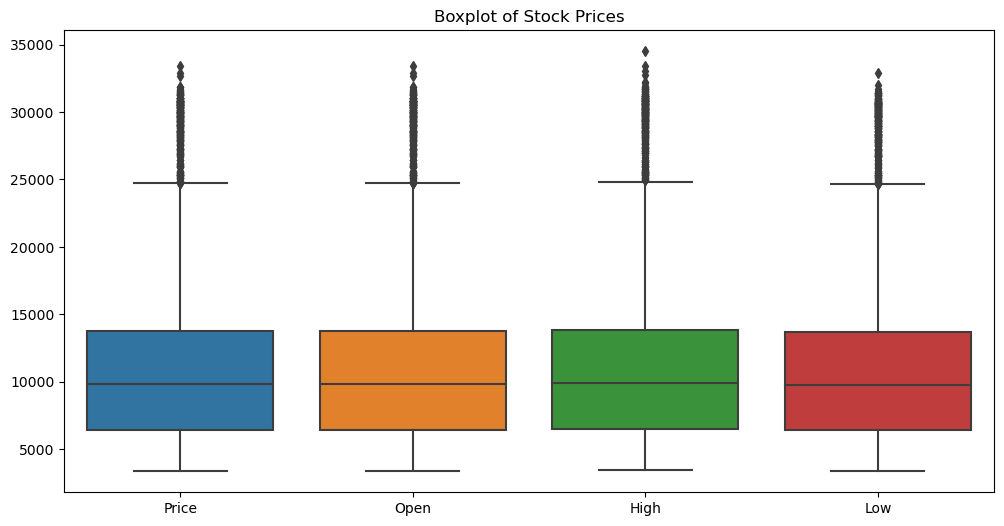

Price    282
Open     281
High     287
Low      277
dtype: int64

In [91]:
# Plot boxplots to detect outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[["Price", "Open", "High", "Low"]])
plt.title("Boxplot of Stock Prices")
plt.show()

# Check for statistical outliers using IQR
Q1 = df[["Price", "Open", "High", "Low"]].quantile(0.25)
Q3 = df[["Price", "Open", "High", "Low"]].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[["Price", "Open", "High", "Low"]] < (Q1 - 1.5 * IQR)) | 
            (df[["Price", "Open", "High", "Low"]] > (Q3 + 1.5 * IQR))).sum()

outliers

In [92]:
outlier_condition = (df[["Price", "Open", "High", "Low"]] < (Q1 - 1.5 * IQR)) | (df[["Price", "Open", "High", "Low"]] > (Q3 + 1.5 * IQR))
outliers_df = df[outlier_condition.any(axis=1)]

# Display the first few rows of detected outliers
outliers_df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,2025-02-06,30011.84,29735.59,30011.84,29735.59,83500000.0,0.0093
1,2025-02-05,29735.59,29668.47,29772.63,29596.50,103710000.0,0.0023
2,2025-02-04,29668.47,29754.77,29937.39,29668.47,135050000.0,-0.0029
3,2025-02-03,29754.77,29917.96,30001.23,29698.79,152060000.0,-0.0055
4,2025-02-02,29917.96,30010.62,30198.22,29917.96,103160000.0,-0.0031
5,2025-01-30,30010.62,29891.61,30127.35,29891.61,127580000.0,0.0040
6,2025-01-29,29891.61,29646.60,29982.32,29646.60,112710000.0,0.0083
7,2025-01-28,29646.60,29742.12,29900.15,29646.60,63280000.0,-0.0032
8,2025-01-27,29742.12,30034.85,30091.04,29726.66,90870000.0,-0.0097
9,2025-01-26,30034.85,29997.69,30276.52,29995.30,76040000.0,0.0012


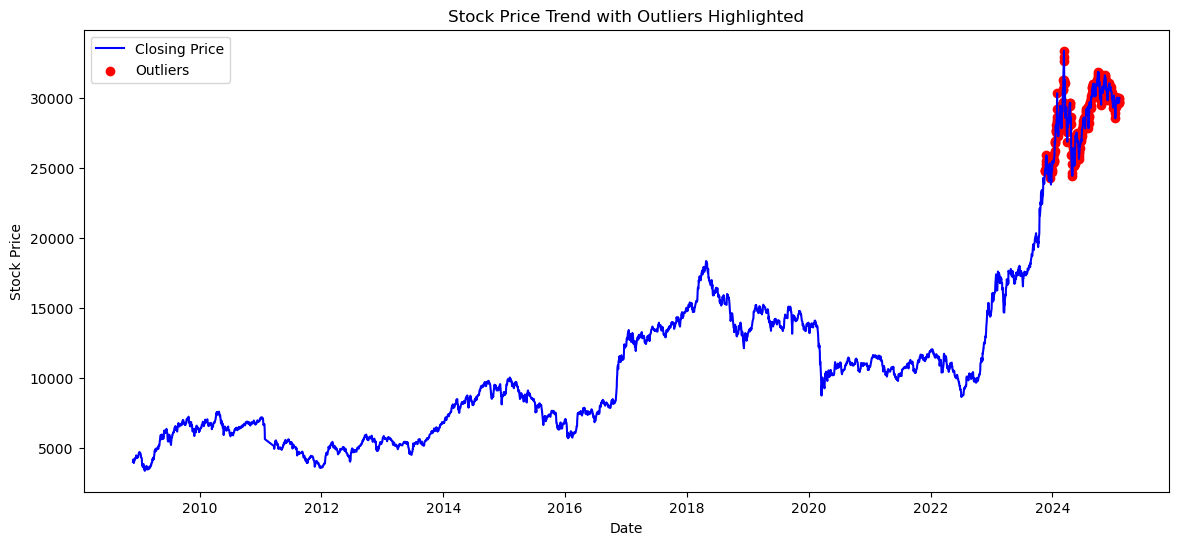

In [93]:
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["Price"], label="Closing Price", color="blue")
plt.scatter(outliers_df["Date"], outliers_df["Price"], color="red", label="Outliers")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Trend with Outliers Highlighted")
plt.legend()
plt.show()

During **2023 and 2024** , Egypt experienced significant economic events and policy changes that likely influenced stock prices:

**Economic Events**

- Inflation Surge: Annual inflation rates reached a peak of 38% in September 2023, before easing to 24% in January 2025.
  ([TRADINGECONOMICS.COM](https://tradingeconomics.com/egypt/inflation-cpi))

- GDP Growth Decline: The real GDP growth rate slowed to 2.4% in the fourth quarter of the fiscal year 2023/2024, down from 3.8% the previous year.
  ([MPED.GOV.EG](https://mped.gov.eg/singlenews?id=5718&lang=en&utm_source=chatgpt.com))

**Government Policies**

- Minimum Wage Increase: In February 2025, the government announced a raise in the monthly minimum wage for public sector workers to 7,000 Egyptian pounds, effective July 2025.
  ([REUTERS.COM](https://www.reuters.com/world/africa/egypt-raise-monthly-minimum-wages-public-sector-workers-2025-02-26/?utm_source=chatgpt.com))

- Social Protection Initiatives: An 80-85 billion Egyptian pounds social protection package was introduced, including increased support for the ration card system, benefiting 10 million vulnerable families.
  ([REUTERS.COM](https://www.reuters.com/world/africa/egypt-raise-monthly-minimum-wages-public-sector-workers-2025-02-26/?utm_source=chatgpt.com))


# Exploratory Data Analysis (EDA)


In [94]:
print(df.describe())

              Price          Open          High           Low          Vol.  \
count   3906.000000   3906.000000   3906.000000   3906.000000  3.906000e+03   
mean   11158.756915  11154.666736  11242.017386  11082.929224  1.432738e+08   
std     6388.627323   6381.427839   6453.659057   6330.857369  1.047258e+08   
min     3389.310000   3389.310000   3484.100000   3380.330000  9.310000e+06   
25%     6457.602500   6456.152500   6494.240000   6422.047500  7.400250e+07   
50%     9860.015000   9865.140000   9925.195000   9789.980000  1.155350e+08   
75%    13776.070000  13770.892500  13846.045000  13719.602500  1.812350e+08   
max    33382.510000  33382.510000  34499.420000  32919.950000  1.640000e+09   

          Change %  
count  3906.000000  
mean      0.000664  
std       0.015015  
min      -0.105200  
25%      -0.006800  
50%       0.000900  
75%       0.008500  
max       0.075900  


- Price, Open, High, Low Similarities:
  The mean values for Price, Open, High, and Low are very close, and their quartiles are almost identical. This implies that on most days, the opening, closing, and extreme prices (high and low) do not differ dramatically. In other words, the intraday price fluctuation tends to be small compared to the overall price level.


### Trend Analysis


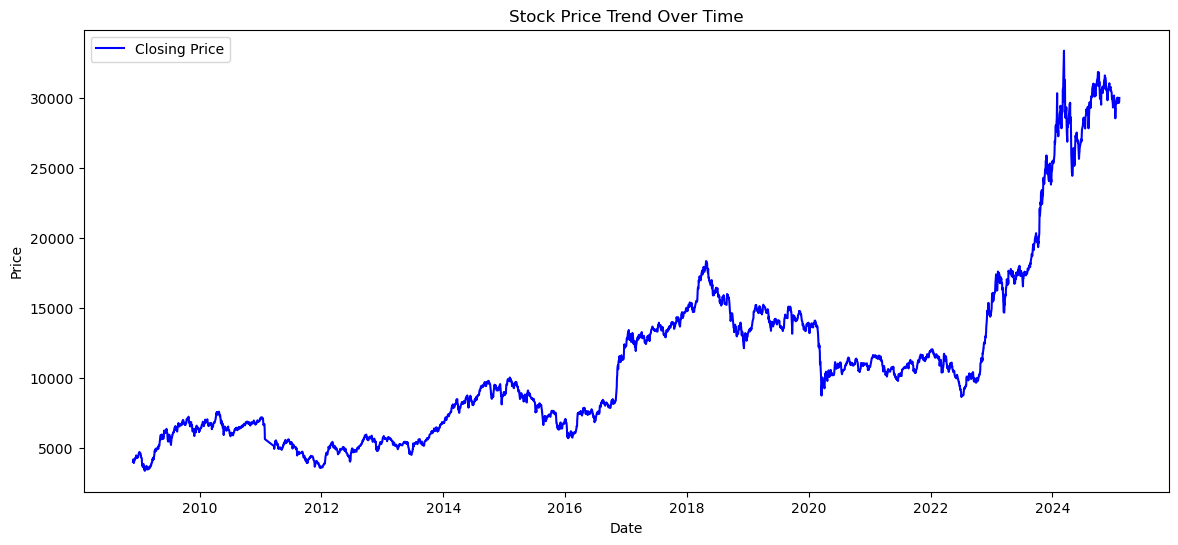

In [95]:
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["Price"], label="Closing Price", color="blue")
plt.title("Stock Price Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

### Seasonal Decomposition on Daily Data


In [96]:
from statsmodels.tsa.seasonal import seasonal_decompose


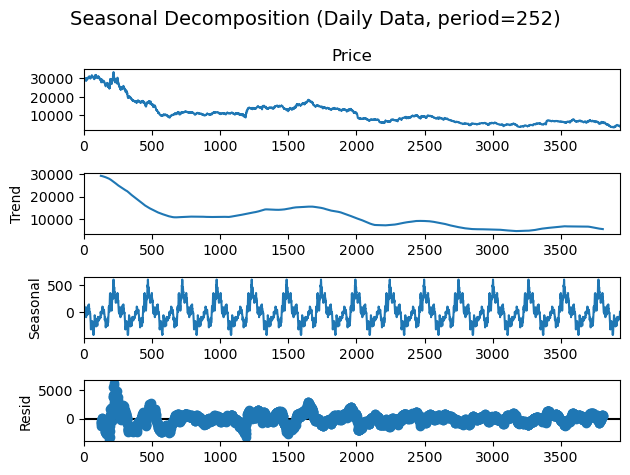

In [97]:
decompose_result = seasonal_decompose(df["Price"], model='additive', period=252)
decompose_result.plot()
plt.suptitle("Seasonal Decomposition (Daily Data, period=252)", fontsize=14)
plt.tight_layout()
plt.show()

### Weekly Decomposition


In [98]:
df_weekly = df.resample("W", on="Date").mean().reset_index()

#  Decompose the weekly time series
df_weekly_for_decomp = df_weekly.copy()
df_weekly_for_decomp.index = pd.DatetimeIndex(df_weekly_for_decomp["Date"])


df_weekly_for_decomp["Price"] = df_weekly_for_decomp["Price"].ffill()

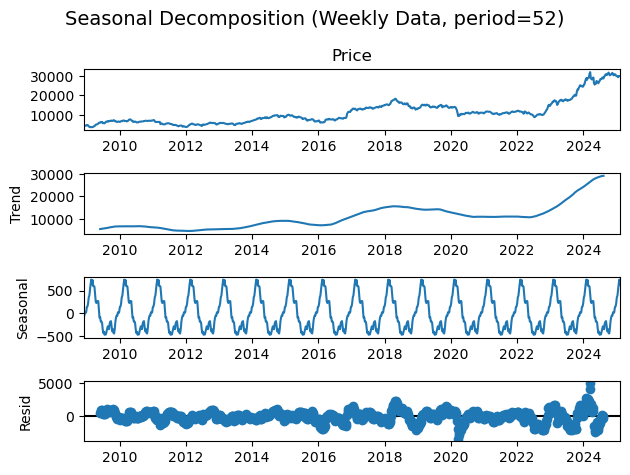

In [99]:

result_weekly = seasonal_decompose(df_weekly_for_decomp["Price"], model='additive', period=52)
result_weekly.plot()
plt.suptitle("Seasonal Decomposition (Weekly Data, period=52)", fontsize=14)
plt.tight_layout()
plt.show()

### Monthly Decomposition


In [100]:
df_monthly = df.resample("M", on="Date").mean().reset_index()

df_monthly_for_decomp = df_monthly.copy()
df_monthly_for_decomp.index = pd.DatetimeIndex(df_monthly_for_decomp["Date"])

df_monthly_for_decomp["Price"] = df_monthly_for_decomp["Price"].ffill()

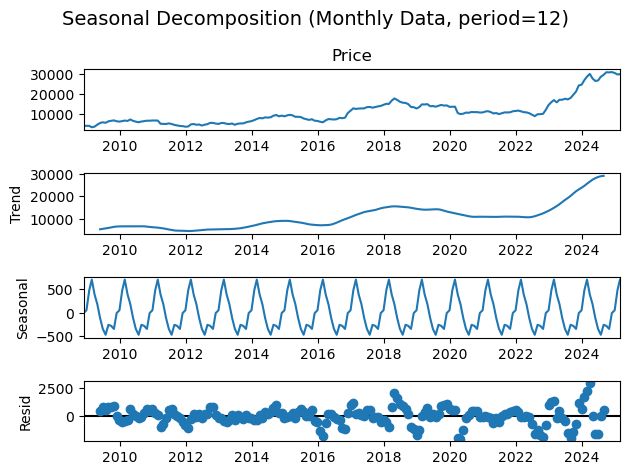

In [101]:
result_monthly = seasonal_decompose(df_monthly_for_decomp["Price"], model='additive', period=12)
result_monthly.plot()
plt.suptitle("Seasonal Decomposition (Monthly Data, period=12)", fontsize=14)
plt.tight_layout()
plt.show()

### Correlation analysis


In [102]:
numerical_features= df.select_dtypes(include=['float64']).copy()

In [103]:
corr_matrix = numerical_features.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
             Price      Open      High       Low      Vol.  Change %
Price     1.000000  0.999584  0.999791  0.999822  0.324710  0.021563
Open      0.999584  1.000000  0.999832  0.999763  0.322699 -0.000454
High      0.999791  0.999832  1.000000  0.999714  0.325433  0.009742
Low       0.999822  0.999763  0.999714  1.000000  0.322570  0.011856
Vol.      0.324710  0.322699  0.325433  0.322570  1.000000  0.118769
Change %  0.021563 -0.000454  0.009742  0.011856  0.118769  1.000000


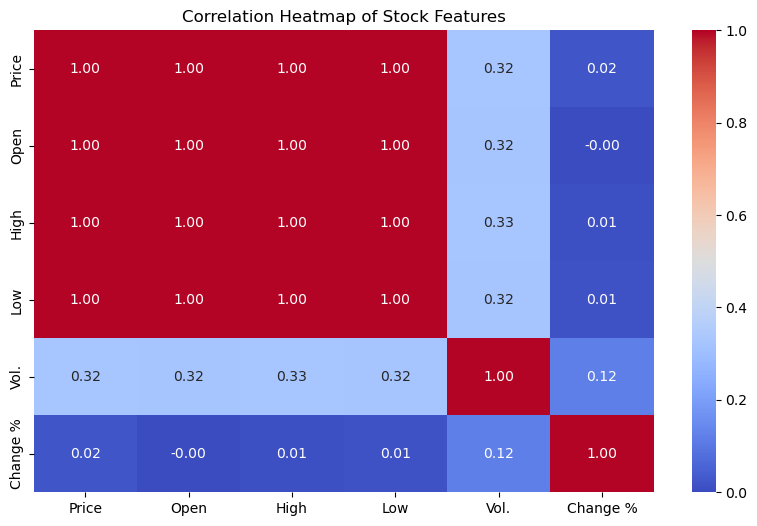

In [104]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Stock Features")
plt.show()

## Feature Engineering


### Moving Averages


In [105]:
df['MA7'] = df['Price'].rolling(window=7).mean()
df['MA30'] = df['Price'].rolling(window=30).mean()

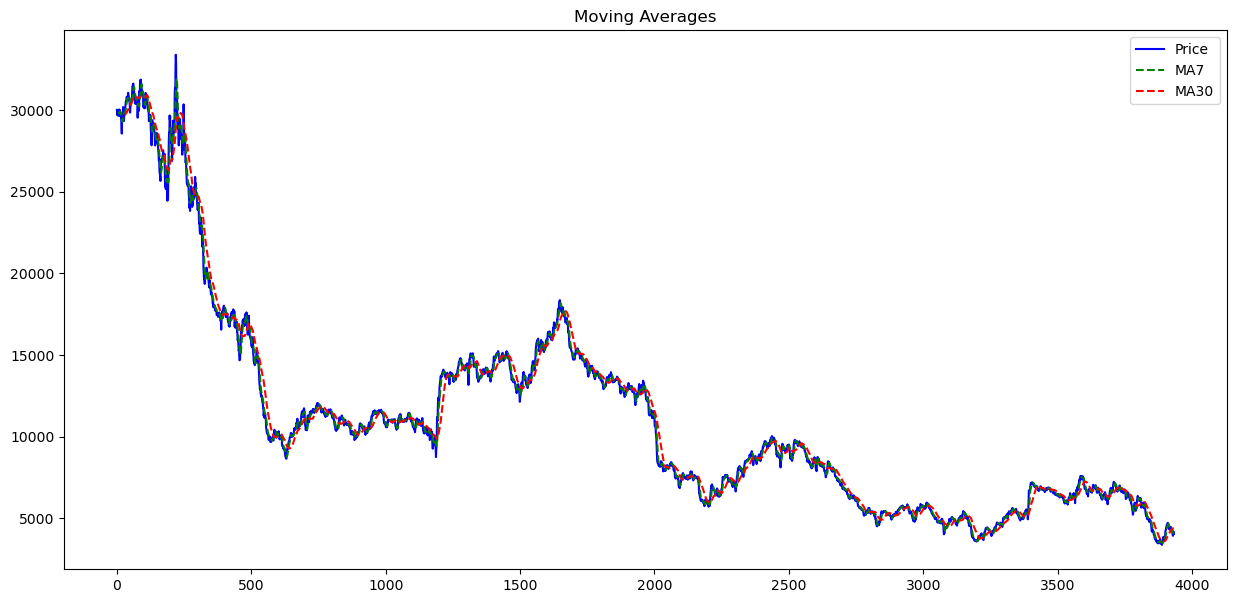

In [106]:
plt.figure(figsize=(15,7))
plt.plot(df['Price'], label='Price', color='blue')
plt.plot(df['MA7'], label='MA7', linestyle='dashed', color='green')
plt.plot(df['MA30'], label='MA30', linestyle='dashed', color='red')
plt.legend()
plt.title('Moving Averages')
plt.show()


**MA7** (7-day) (green line) tracks the Price closely, reacting more quickly to short-term fluctuations. You can see that it moves almost in sync with the Price, but with slightly smoother peaks and troughs.

**MA30** (30-day) (red, dashed line) is smoother and lags behind the immediate price changes. It captures a more medium-term trend, filtering out much of the short-term volatility.


Given the overall decline in Price, both MAs confirm a sustained downward movement, though the 7-day MA shows smaller wiggles along the way.

This can be indicative of a prolonged bear market in the period captured by the data, with short rallies that don’t significantly alter the longer downward trend.


### Daily Return


In [107]:
df["Daily Return"] = df["Price"].pct_change()

In [108]:
df["Daily Range"] = df["High"] - df["Low"]

In [109]:
df["Price Change"] = df["Price"] - df["Open"]

### Rolling Volatility


In [110]:
df["Volatility"] = df["Daily Return"].rolling(window=7).std()

<Figure size 1400x1000 with 0 Axes>

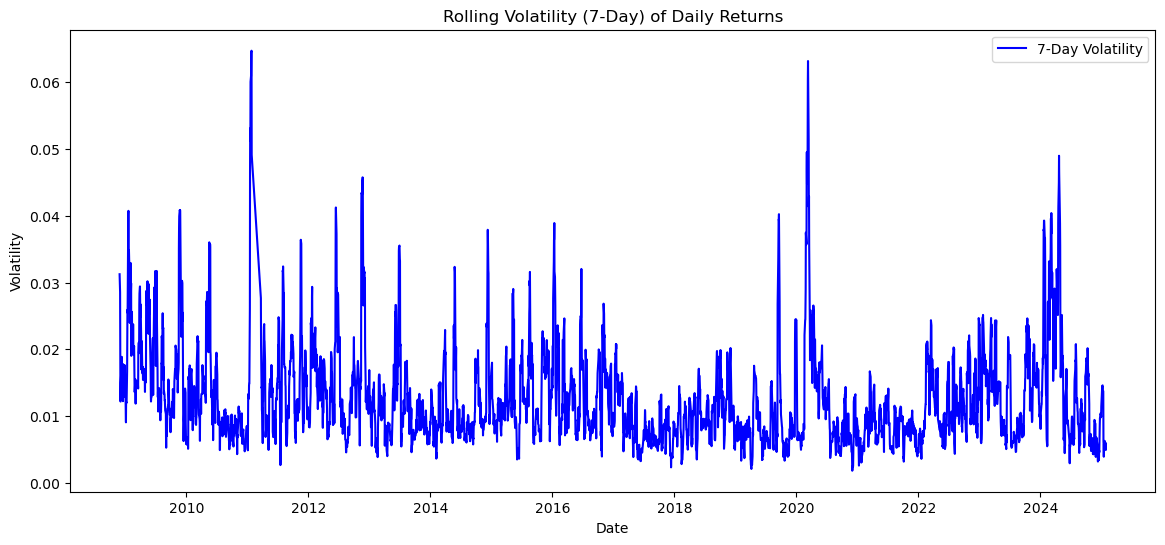

In [111]:
plt.figure(figsize=(14, 10))
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["Volatility"], label="7-Day Volatility", color="blue")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Rolling Volatility (7-Day) of Daily Returns")
plt.legend()
plt.show()

**Spiky Periods**:

- The chart shows multiple volatility spikes—some reaching above 0.04–0.06 (or 4–6% in daily return standard deviation).
- These spikes could be linked to major news events, economic crises, currency devaluations, or political changes that caused rapid price swings.

**Quiet Periods**:

- Between spikes, volatility often settles below 0.01–0.02.
- Low volatility suggests more stable or less reactive market conditions over those weeks.


### Relative Strength Index (RSI)


In [112]:
def compute_rsi(df, column='Price', window=14):
    delta = df[column].diff(1)  # Calculate the price change

    gain = delta.where(delta > 0, 0)  # Keep gains, replace losses with 0
    loss = -delta.where(delta < 0, 0)  # Keep losses, replace gains with 0

    avg_gain = gain.rolling(window=window, min_periods=window).mean()  # Average gain over 14 days
    avg_loss = loss.rolling(window=window, min_periods=window).mean()  # Average loss over 14 days

    rs = avg_gain / avg_loss.replace(0, np.nan) # Relative Strength (RS)
    rsi = 100 - (100 / (1 + rs))  # RSI Calculation

    df['RSI'] = rsi  # Add RSI to DataFrame
    return df

# Apply RSI function to DataFrame
df = compute_rsi(df)

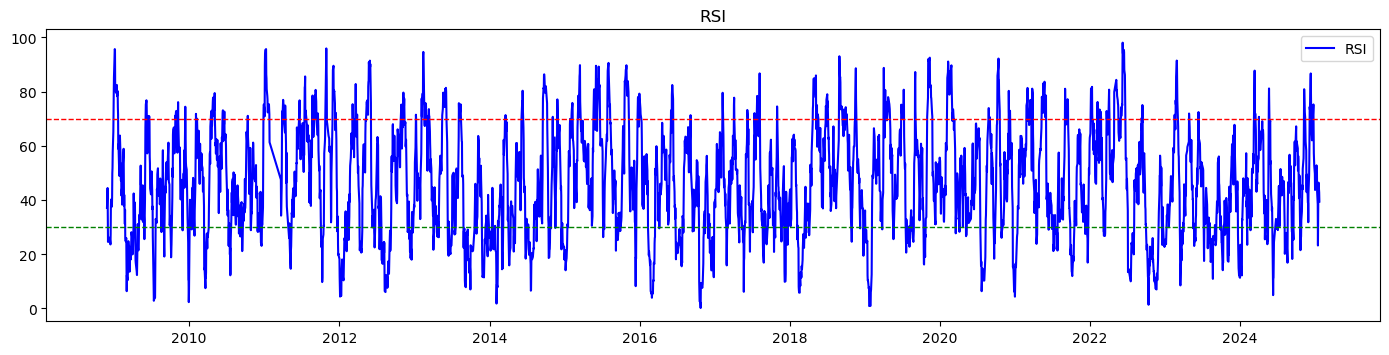

In [113]:
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 3)
plt.plot(df["Date"], df["RSI"], label="RSI", color="blue")
plt.axhline(70, color="red", linestyle="--", linewidth=1)
plt.axhline(30, color="green", linestyle="--", linewidth=1)
plt.title("RSI")
plt.legend()

plt.tight_layout()
plt.show()


**Above 70–80** (red line ) often suggests overbought conditions.

**Below 20–30** (green line) often suggests oversold conditions.


The RSI is highly active, indicating frequent shifts in momentum.

Overbought and oversold zones are reached regularly, suggesting either a short calculation period or a very volatile market.


### Moving Average Convergence Divergence (MACD)


In [114]:
import ta


In [115]:
df["MACD"] = ta.trend.MACD(df["Price"]).macd()

In [116]:
df["Signal Line"] = df["MACD"].ewm(span=9, adjust=False).mean()

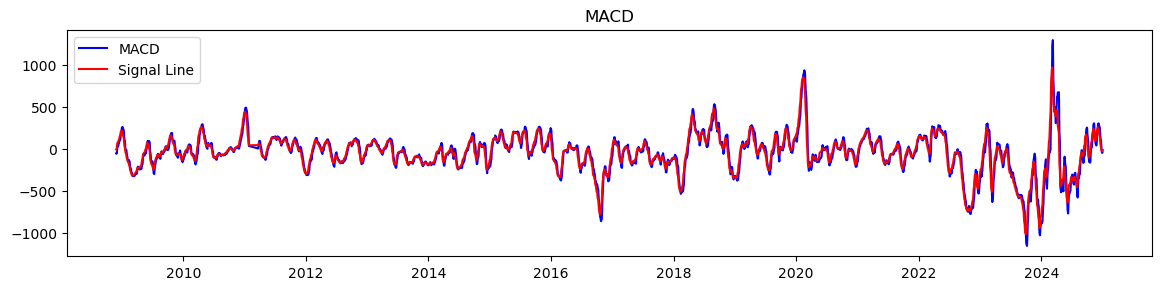

In [117]:
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 2)
plt.plot(df["Date"], df["MACD"], label="MACD", color="blue")
plt.plot(df["Date"], df["Signal Line"], label="Signal Line", color="red")
plt.title("MACD")
plt.legend()

**Frequent Crossovers**

- The blue and red lines cross multiple times, suggesting frequent momentum changes.
- Each crossover can be interpreted as a shift in short-term vs. long-term momentum.

**Large Swings**

- Notable spikes occur around 2016, 2020, and 2024, with the MACD moving above or below ±500–1000.
- These spikes indicate strong bullish or bearish momentum, likely tied to major price moves or market events.

**Periods Near Zero**

- There are intervals where MACD and the Signal Line hover near zero, suggesting relatively balanced momentum or a sideways market.


### Bollinger Bands


In [118]:
bb = ta.volatility.BollingerBands(df["Price"], window=20)
df["BB_High"] = bb.bollinger_hband()
df["BB_Low"] = bb.bollinger_lband()

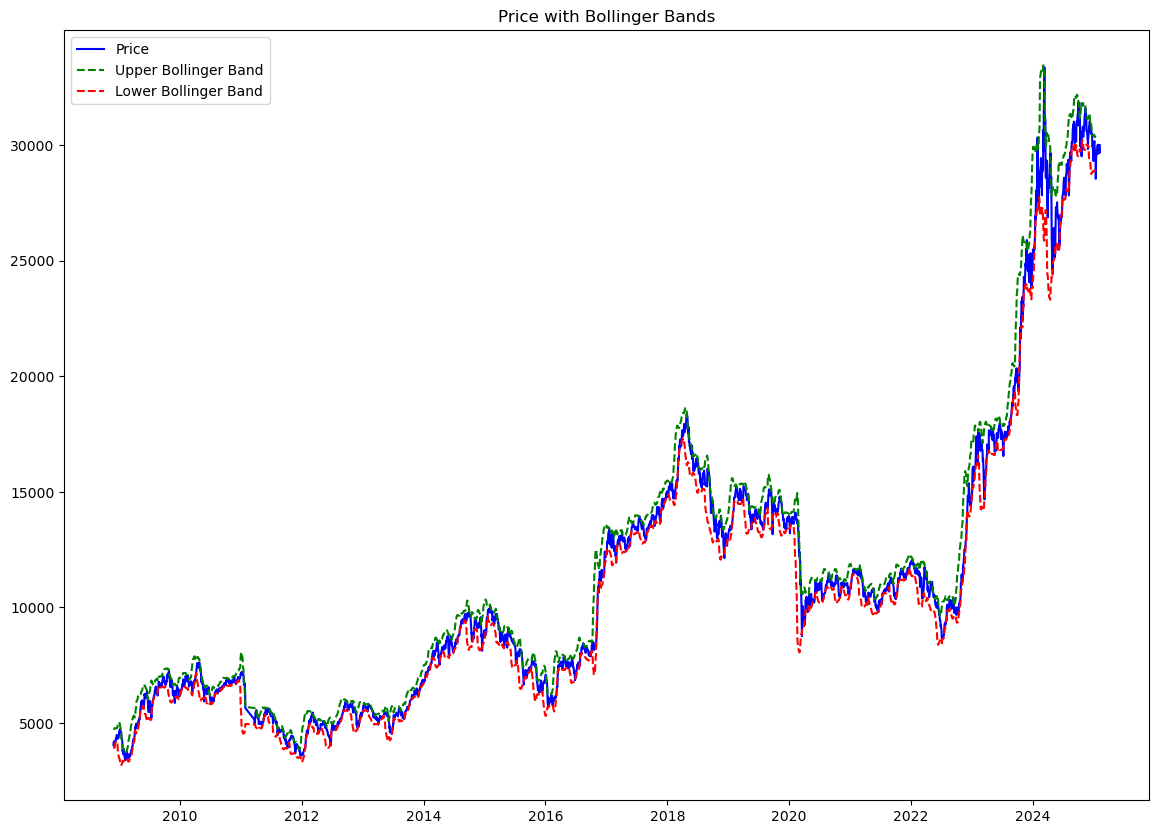

In [119]:
plt.figure(figsize=(14, 10))
plt.plot(df["Date"], df["Price"], label="Price", color="blue")
plt.plot(df["Date"], df["BB_High"], label="Upper Bollinger Band", linestyle="--", color="green")
plt.plot(df["Date"], df["BB_Low"], label="Lower Bollinger Band", linestyle="--", color="red")
plt.title("Price with Bollinger Bands")
plt.legend()


Upper Band (green, dotted) and Lower Band (red, dotted) typically lie ±2 standard deviations from a 20-day moving average (the middle band).

They expand when volatility (standard deviation) increases and contract when volatility decreases.


**Long-Term Uptrend**
The chart shows a steady rise from below 5,000 in early years (2008–2010) to over 30,000 by 2024–2025.
Notably, there’s an accelerated climb from around 2020 onward.

**Periods of High Volatility**
When the price surges sharply (e.g., 2020–2025), the bands widen significantly, reflecting larger price swings.
Around major price peaks, the upper band is far above the middle band, indicating increased volatility.

**Band Touches and Mean Reversion**
During strong uptrends, the price can stay near the upper band for extended periods, suggesting bullish momentum.
When price touches or crosses below the lower band, it may signal oversold conditions or a downward correction.


**The chart confirms a strong long-term uptrend with phases of high volatility, especially post-2020.**


### Quarter of the Year


In [120]:
df["Quarter"] = df["Date"].dt.quarter

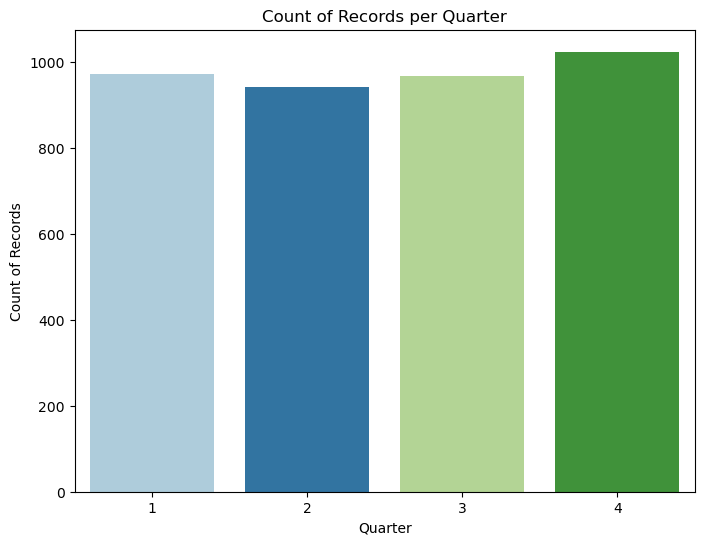

In [121]:
plt.figure(figsize=(8, 6))
quarter_counts = df["Quarter"].value_counts().sort_index()
sns.barplot(x=quarter_counts.index, y=quarter_counts.values, palette="Paired")
plt.xlabel("Quarter")
plt.ylabel("Count of Records")
plt.title("Count of Records per Quarter")
plt.show()


Each quarter has roughly 900–1000 records, indicating the dataset is fairly balanced across Q1, Q2, Q3, and Q4.

The dataset may include partial-year data that skews toward Q4.


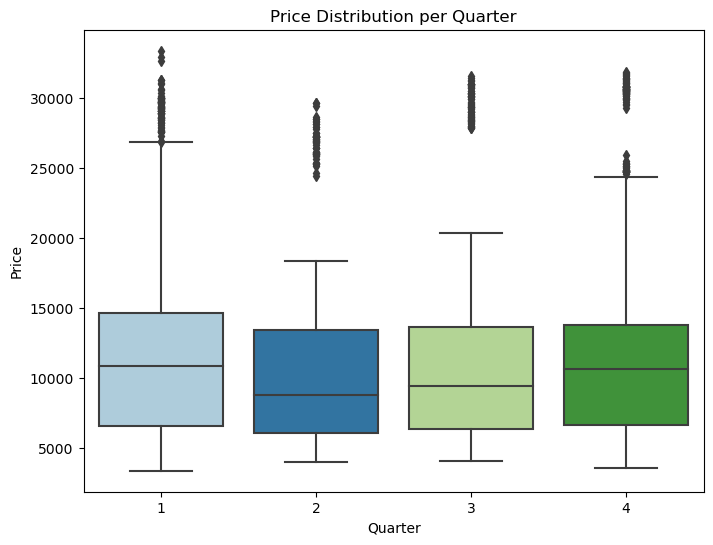

In [122]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Quarter", y="Price", data=df, palette="Paired")
plt.xlabel("Quarter")
plt.ylabel("Price")
plt.title("Price Distribution per Quarter")
plt.show()

Q2 shows a lower median price, raising questions about potential seasonal dips or partial data coverage.

The presence of outliers in all quarters indicates significant price spikes at various times, not confined to any single quarter.


### Average True Range (ATR)


In [123]:
df["Previous_Close"] = df["Price"].shift(1)

df["High_Low"] = df["High"] - df["Low"]
df["High_PC"] = (df["High"] - df["Previous_Close"]).abs()  
df["Low_PC"] = (df["Low"] - df["Previous_Close"]).abs()    

df["TR"] = df[["High_Low", "High_PC", "Low_PC"]].max(axis=1)

**High_Low**: The difference between the current day’s high and low.

**High_PC**: The absolute difference between the current day’s high and the previous day’s close.

**Low_PC**: The absolute difference between the current day’s low and the previous day’s close.

**The TR** is then the maximum of these three values for each day.


In [124]:
window = 14
df["ATR"] = df["TR"].rolling(window=window, min_periods=window).mean()

In [125]:
print(df[["Date", "Price", "High", "Low", "Previous_Close", "TR", "ATR"]].tail(20))

           Date    Price     High      Low  Previous_Close      TR         ATR
3913 2008-12-30  4487.47  4488.82  4351.39         4596.49  245.10  180.637143
3914 2008-12-28  4351.39  4358.27  4320.50         4487.47  166.97  161.216429
3915 2008-12-25  4357.96  4400.92  4331.88         4351.39   69.04  141.167143
3916 2008-12-24  4331.88  4411.78  4271.82         4357.96  139.96  141.497143
3917 2008-12-23  4324.27  4361.91  4324.23         4331.88   37.68  131.569286
3918 2008-12-22  4351.38  4386.83  4312.38         4324.27   74.45  120.160000
3919 2008-12-21  4325.77  4453.40  4325.65         4351.38  127.75  120.485714
3920 2008-12-18  4453.40  4516.73  4453.29         4325.77  190.96  124.678571
3921 2008-12-17  4484.01  4509.07  4434.97         4453.40   74.10  125.862143
3922 2008-12-16  4434.97  4450.81  4366.68         4484.01  117.33  127.942143
3923 2008-12-15  4366.68  4366.68  4291.37         4434.97  143.60  127.144286
3924 2008-12-14  4302.03  4329.45  4290.77         4

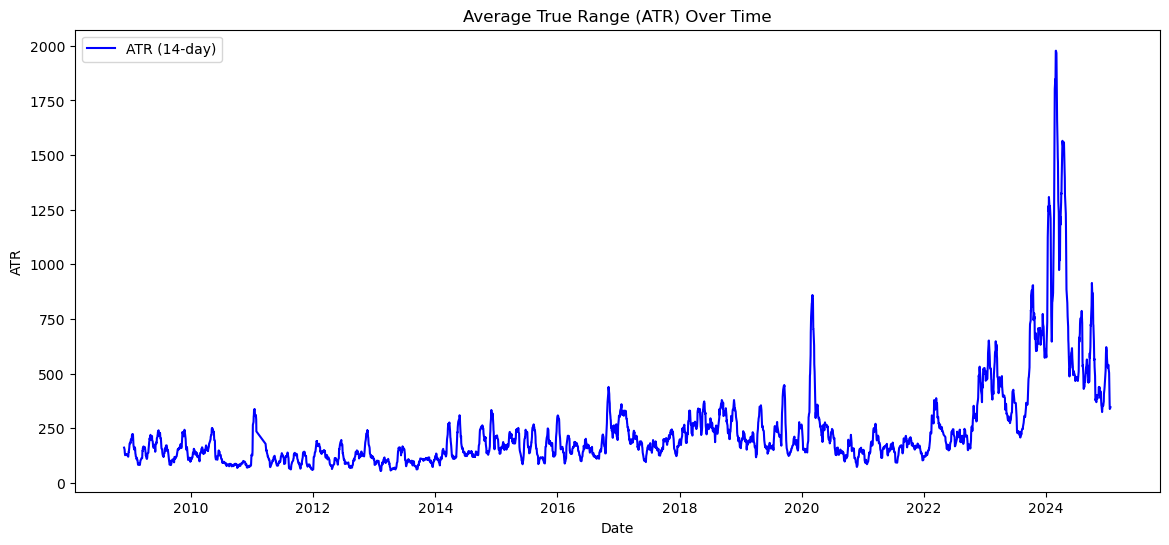

In [126]:
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["ATR"], label="ATR (14-day)", color="blue")
plt.xlabel("Date")
plt.ylabel("ATR")
plt.title("Average True Range (ATR) Over Time")
plt.legend()
plt.show()

**Relatively Low ATR (2008–2020)**
From 2008 through much of the early 2010s, the ATR remains below 200–300, indicating relatively lower volatility compared to later years.

**Significant Increase (2020–2025)**
Post-2020, the ATR shows sizable and frequent spikes, with peaks surpassing 500–1000, and at one point reaching around 2000.


Long-Term Perspective: The market was relatively less volatile before 2020, with dramatic volatility spikes in the 2023–2024 period.


### Stochastic Oscillator


In [127]:
k_period = 14  # Look-back period for %K
d_period = 3   # Moving average period for %D

In [128]:
df['Lowest_Low'] = df['Low'].rolling(window=k_period).min()
df['Highest_High'] = df['High'].rolling(window=k_period).max()

In [129]:
df['%K'] = 100 * ((df['Price'] - df['Lowest_Low']) / (df['Highest_High'] - df['Lowest_Low']))

In [130]:
df['%D'] = df['%K'].rolling(window=d_period).mean()

In [131]:
print(df[["Date", "Price", "Lowest_Low", "Highest_High", "%K", "%D"]].tail(10))

           Date    Price  Lowest_Low  Highest_High         %K         %D
3923 2008-12-15  4366.68     4271.82       4745.76  20.015192  30.857100
3924 2008-12-14  4302.03     4271.82       4719.22   6.752347  19.435229
3925 2008-12-11  4319.74     4192.16       4621.72  29.700158  18.822566
3926 2008-12-10  4202.25     4059.08       4516.73  31.283732  22.578746
3927 2008-12-04  4059.08     3969.34       4516.73  16.394161  25.792684
3928 2008-12-03  3979.71     3969.34       4516.73   1.894445  16.524113
3929 2008-12-02  3937.66     3829.44       4516.73  15.745901  11.344835
3930 2008-12-01  4022.58     3829.44       4516.73  28.101675  15.247340
3931 2008-11-30  4205.86     3829.44       4516.73  54.768729  32.872102
3932 2008-11-27  4043.72     3829.44       4516.73  31.177523  38.015976


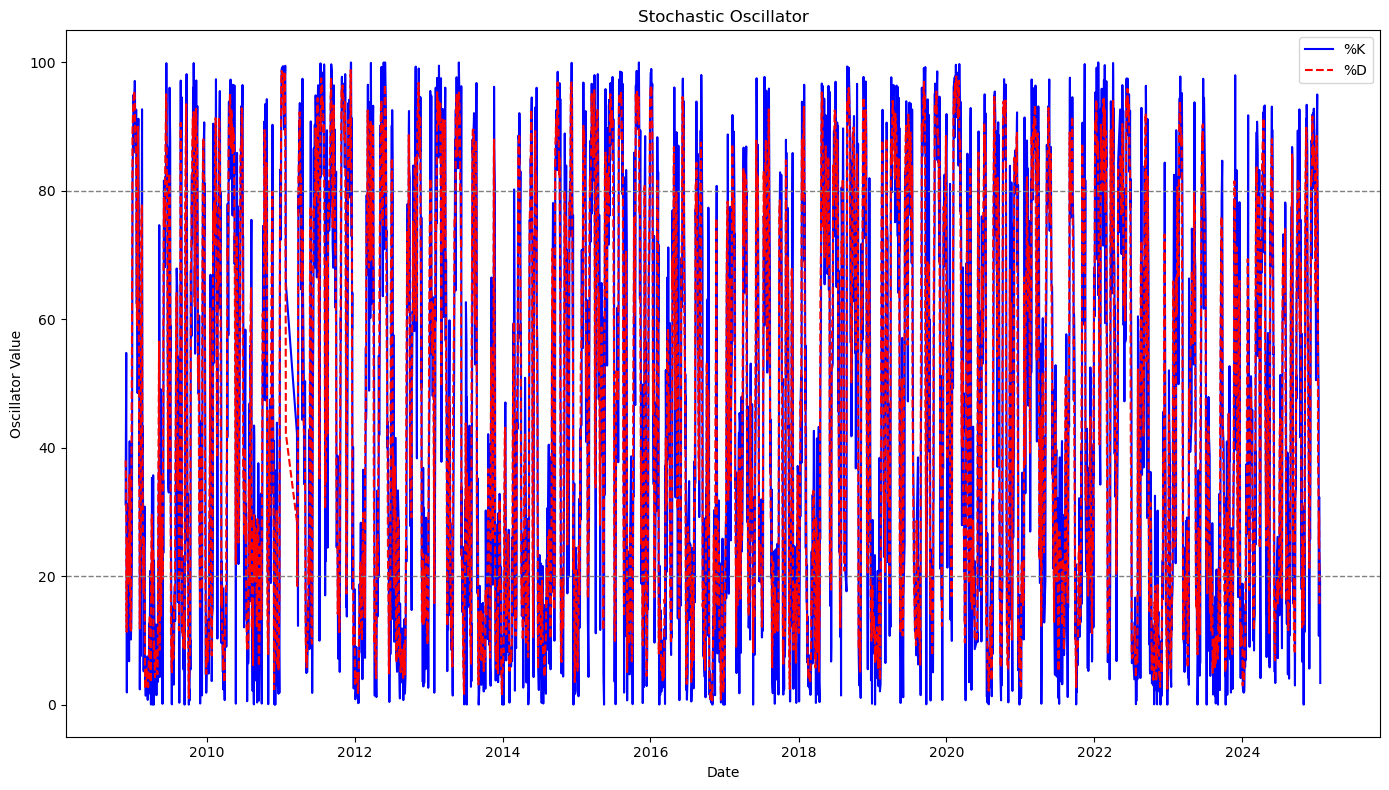

In [132]:
plt.figure(figsize=(14, 8))


plt.plot(df["Date"], df["%K"], label="%K", color="blue")
plt.plot(df["Date"], df["%D"], label="%D", color="red", linestyle="--")


plt.axhline(80, color="gray", linestyle="--", linewidth=1)
plt.axhline(20, color="gray", linestyle="--", linewidth=1)

plt.title("Stochastic Oscillator")
plt.xlabel("Date")
plt.ylabel("Oscillator Value")
plt.legend()
plt.tight_layout()
plt.show()

Above 80 typically indicating overbought conditions.
Below 20 typically indicating oversold conditions.


**Frequent Spikes**

The oscillator oscillates rapidly between 0 and 100, suggesting either a very short lookback period (like 14 days for %K) or a highly volatile market—or both.

The lines (%K and %D) crisscross frequently, generating many potential overbought/oversold signals.

**No Extended Flat Regions**

The plot shows the oscillator rarely stays pinned at the top or bottom for long. Instead, it quickly reverts, indicating constant shifts in momentum.

**Volatile Environment**

When prices are volatile or the time period for the Stochastic calculation is short, the oscillator can produce frequent whipsaws, requiring additional confirmation from other indicators or higher smoothing.


**The Stochastic Oscillator is highly active**


### Correlation analysis


In [133]:
numerical_features= df.select_dtypes(include=['float64']).copy()

In [134]:
corr_matrix = numerical_features.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                   Price      Open      High       Low      Vol.  Change %  \
Price           1.000000  0.999584  0.999791  0.999822  0.324710  0.021563   
Open            0.999584  1.000000  0.999832  0.999763  0.322699 -0.000454   
High            0.999791  0.999832  1.000000  0.999714  0.325433  0.009742   
Low             0.999822  0.999763  0.999714  1.000000  0.322570  0.011856   
Vol.            0.324710  0.322699  0.325433  0.322570  1.000000  0.118769   
Change %        0.021563 -0.000454  0.009742  0.011856  0.118769  1.000000   
MA7             0.999041  0.998558  0.998815  0.998821  0.329991  0.025277   
MA30            0.995090  0.994606  0.994899  0.994808  0.352835  0.028115   
Daily Return    0.001981  0.005105  0.003671  0.004250 -0.048134 -0.176239   
Daily Range     0.625442  0.628694  0.635807  0.617182  0.296387 -0.062209   
Price Change    0.053460  0.024632  0.037620  0.041079  0.082284  0.763009   
Volatility     -0.086004 -0.083917 -0.080641

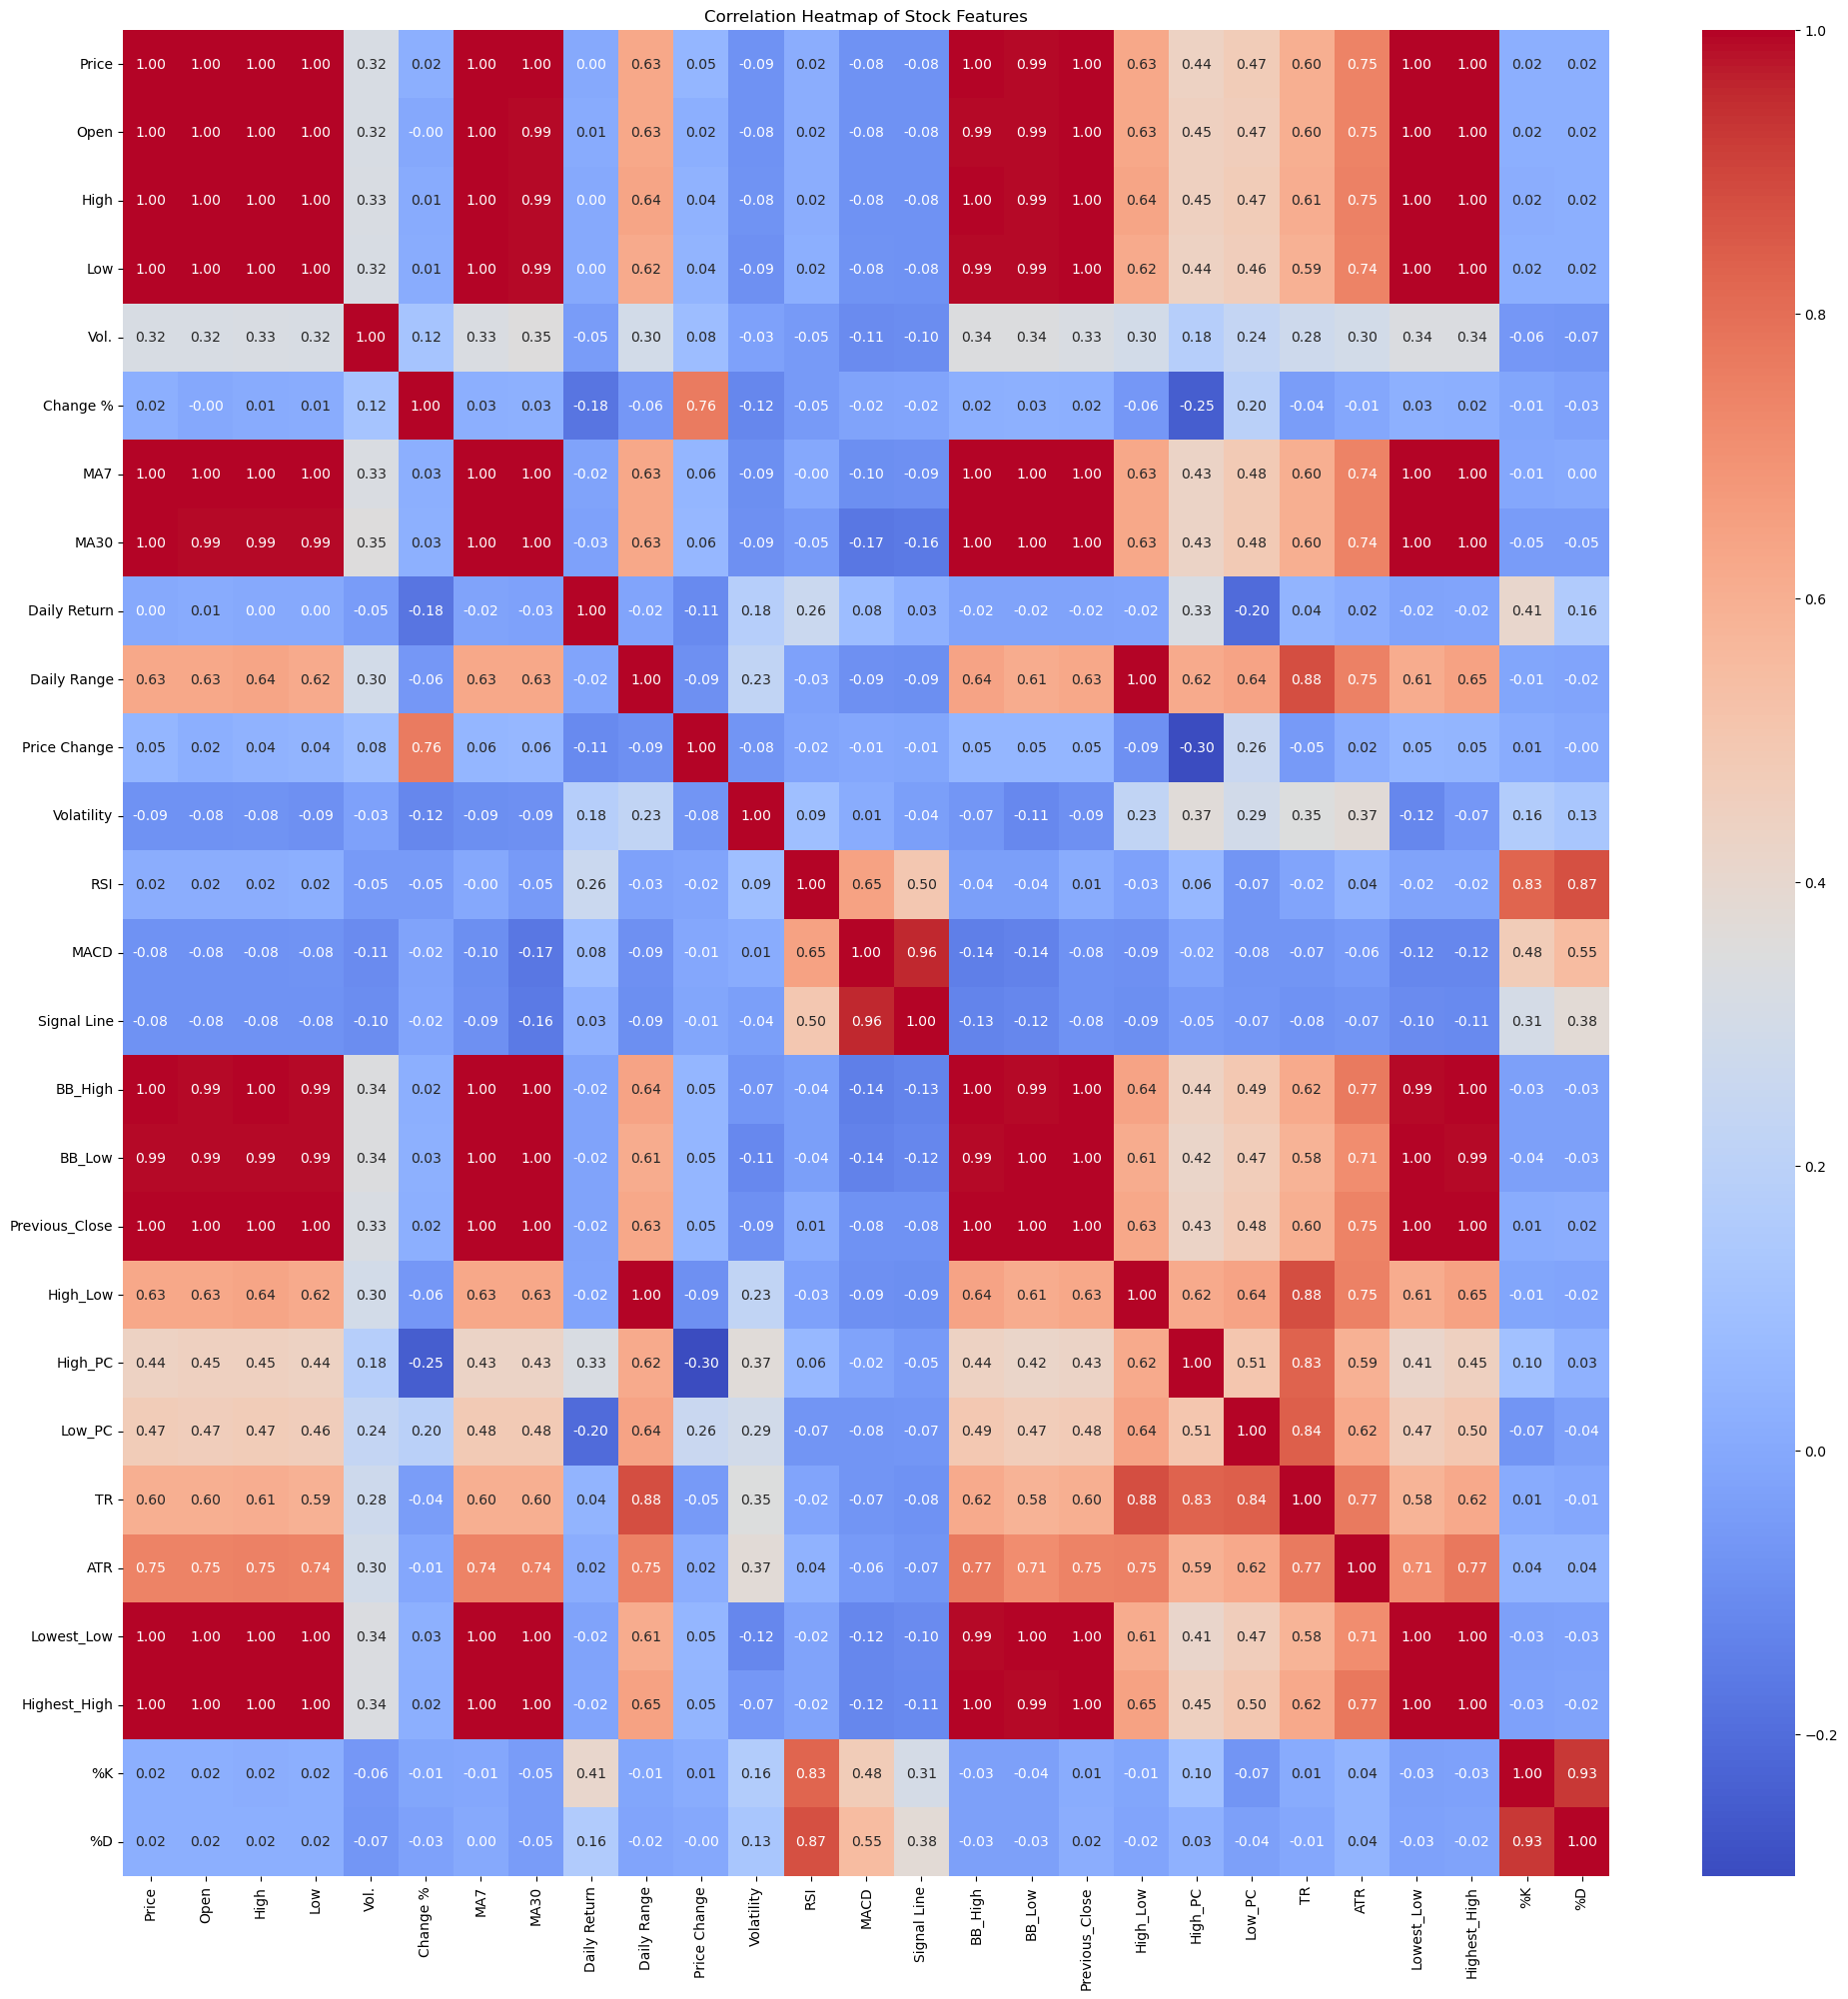

In [135]:
plt.figure(figsize=(24, 24))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Stock Features")
plt.show()

#### **Strongly Correlated Groups**


**Price, Open, High, Low, Previous_Close, MA7, MA30, BB_High, BB_Low, Highest_High, Lowest_Low**

- All are above 0.99 with each other, which means they essentially carry the same price information in different forms.


**Daily Range, TR, ATR, High_Low, High_PC, Low_PC**

These columns measure intraday or rolling volatility in various ways:

- Daily Range ≈ High – Low
- TR (True Range) ≈ max of (High_Low, High_PC, Low_PC)
- ATR is the rolling average of TR, leading to strong correlation.


**RSI, %K, and %D**

- The Stochastic Oscillator lines are highly correlated with each other (0.93).
- RSI also has a high correlation (0.83+) with %K and %D.


**MACD and Signal Line**

- Naturally correlated (both are derived from EMAs of Price).
- Show moderate correlation with RSI/Stochastic (0.30–0.55 range).


#### **Notable Individual Correlations**


**Volume (Vol.)**

- Moderately correlated with Price (~0.32).
- Correlation with volatility measures (ATR, TR) is lower (~0.28).


**Change % vs. Price Change**

- Change % (percentage change) and Price Change (absolute difference) have a strong correlation (~0.76), but each tells a different story:
  - Change % normalizes the price move by the previous close.
  - Price Change is the absolute difference (in points).


**Daily Return**

- Weak correlation with most price features (±0.02 to ±0.01 range).
- Some moderate relationships with volatility measures (e.g., High_PC at ~0.33).


### Feature Selection


**Price (closing price)** (Trend/Level).

**Volume (Vol.)** (Market Participation) is only moderately correlated with price and can reveal liquidity/participation info.

**ATR** (Volatility) is a rolling measure of True Range, and typically more robust for modeling.

**RSI** (Momentum) is a classic overbought/oversold measure.

**MACD** (Momentum) captures momentum shifts between short/long EMAs.

**Daily Return (or Change %)** (Short-Term Change).


In [136]:
selected_features = ["Date", "Price", "Vol.", "ATR", "RSI", "MACD", "Daily Return"]

stock = df[selected_features].copy()


In [137]:
print("Missing Values:\n", stock.isnull().sum())

Missing Values:
 Date             0
Price            0
Vol.             0
ATR             13
RSI             13
MACD            25
Daily Return     1
dtype: int64


In [138]:
stock.dropna(inplace=True)

In [139]:
stock.head()

,Date,Price,Vol.,ATR,RSI,MACD,Daily Return
25,2024-12-31,29740.58,102620000.0,563.995714,46.786344,-13.642200,-0.010642
26,2024-12-30,29325.20,97650000.0,573.322143,43.692508,-43.940238,-0.013967
27,2024-12-29,29594.48,71230000.0,606.342143,49.691446,-45.696247,0.009183
28,2024-12-26,29957.97,53510000.0,621.321429,52.672670,-17.554930,0.012282
29,2024-12-25,30005.00,90650000.0,611.752857,54.744233,8.444848,0.001570


In [140]:
stock2020=stock[stock['Date']>='2020-01-01']

In [141]:
stock2020['Date'] = pd.to_datetime(stock2020['Date'])  
stock2020.set_index('Date', inplace=True)

C:\Users\dell\AppData\Local\Temp\ipykernel_10180\2148031678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock2020['Date'] = pd.to_datetime(stock2020['Date'])


In [142]:
stock2020 = stock2020.asfreq('D')


In [143]:
stock2020.head()

,Price,Vol.,ATR,RSI,MACD,Daily Return
Date,,,,,,
2020-01-02,13899.54,28400000.0,257.677143,54.404309,101.519847,0.051987
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,13212.66,103110000.0,211.699286,34.928176,88.064118,-0.024354


In [144]:
stock2020.tail()

,Price,Vol.,ATR,RSI,MACD,Daily Return
Date,,,,,,
2024-12-27,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-28,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-29,29594.48,71230000.0,606.342143,49.691446,-45.696247,0.009183
2024-12-30,29325.20,97650000.0,573.322143,43.692508,-43.940238,-0.013967
2024-12-31,29740.58,102620000.0,563.995714,46.786344,-13.642200,-0.010642


In [145]:
stock2020.fillna(method='ffill', inplace=True) 

In [146]:
stock2020

,Price,Vol.,ATR,RSI,MACD,Daily Return
Date,,,,,,
2020-01-02,13899.54,28400000.0,257.677143,54.404309,101.519847,0.051987
2020-01-03,13899.54,28400000.0,257.677143,54.404309,101.519847,0.051987
2020-01-04,13899.54,28400000.0,257.677143,54.404309,101.519847,0.051987
2020-01-05,13899.54,28400000.0,257.677143,54.404309,101.519847,0.051987
2020-01-06,13212.66,103110000.0,211.699286,34.928176,88.064118,-0.024354
...,...,...,...,...,...,...
2024-12-27,29957.97,53510000.0,621.321429,52.672670,-17.554930,0.012282
2024-12-28,29957.97,53510000.0,621.321429,52.672670,-17.554930,0.012282
2024-12-29,29594.48,71230000.0,606.342143,49.691446,-45.696247,0.009183


# Modelling


## ARIMA Model


In [147]:
train_size = int(len(stock2020) * 0.8)  # Use 80% for training
train, test = stock2020[:train_size], stock2020[train_size:]

### Build the ARIMA Model


In [149]:
import pmdarima as pm


### Using Auto ARIMA


In [150]:
print("\nFinding best parameters using Auto ARIMA...")
auto_arima_model = pm.auto_arima(train['Price'], 
                                 seasonal=False,  
                                 stepwise=True, 
                                 trace=True)


best_p, best_d, best_q = auto_arima_model.order
print(f"\nBest ARIMA order: ({best_p}, {best_d}, {best_q})")


Finding best parameters using Auto ARIMA...
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=19804.469, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=19436.085, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=19802.471, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=19262.246, Time=0.25 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=19206.426, Time=0.36 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=19147.204, Time=0.51 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=19133.591, Time=0.54 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.37 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.37 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=19131.594, Time=0.24 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=19145.200, Time=0.26 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=3.04 sec
 ARI

In [152]:
from statsmodels.tsa.arima.model import ARIMA


In [153]:
model = ARIMA(train['Price'], order=(best_p, best_d, best_q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1460
Model:                 ARIMA(5, 2, 0)   Log Likelihood               -9559.797
Date:                Sun, 08 Jun 2025   AIC                          19131.594
Time:                        22:08:01   BIC                          19163.303
Sample:                    01-02-2020   HQIC                         19143.423
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7616      0.016    -47.130      0.000      -0.793      -0.730
ar.L2         -0.5922      0.022    -26.547      0.000      -0.636      -0.548
ar.L3         -0.3985      0.023    -17.414      0.0

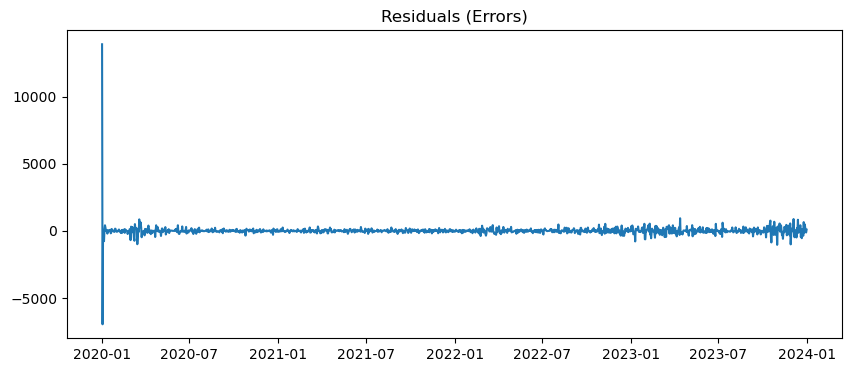

In [154]:
residuals = model_fit.resid

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals (Errors)")
plt.show()

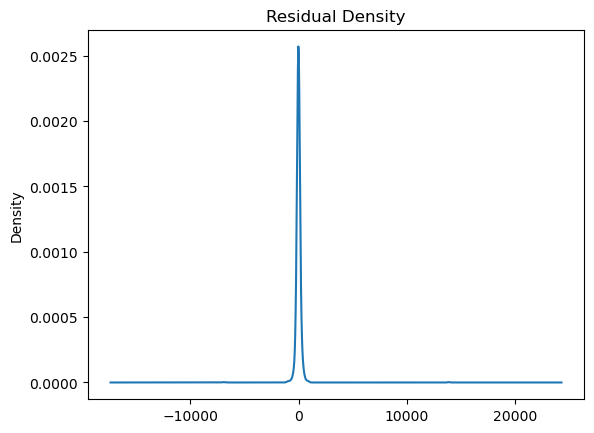

In [ ]:
residuals.plot(kind='kde', title='Residual Density')
plt.show()

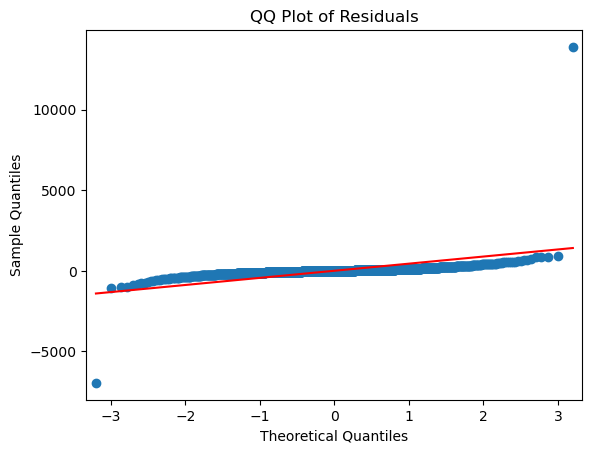

In [ ]:
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.title("QQ Plot of Residuals")
plt.show()


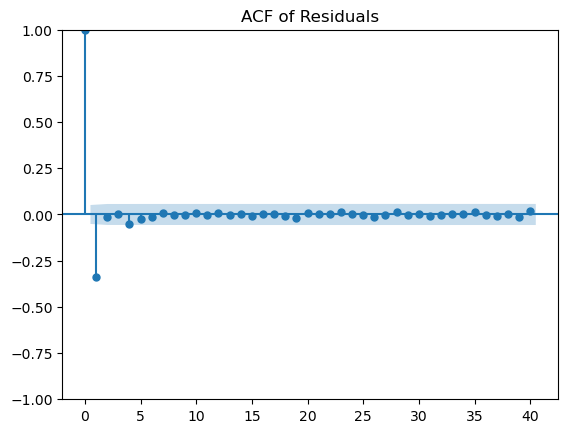

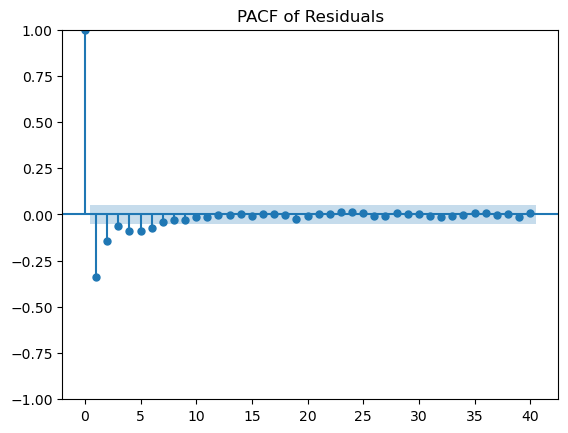

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()

plot_pacf(residuals, lags=40)
plt.title("PACF of Residuals")
plt.show()

In [155]:
forecast_test1 = model_fit.forecast(steps=len(test))

In [156]:
rmse = np.sqrt(mean_squared_error(test['Price'], forecast_test1))
mae = mean_absolute_error(test['Price'], forecast_test1)
mape = np.mean(np.abs((test['Price'] - forecast_test1) / test['Price'])) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 23977.15
MAE: 20227.87
MAPE: 68.69%


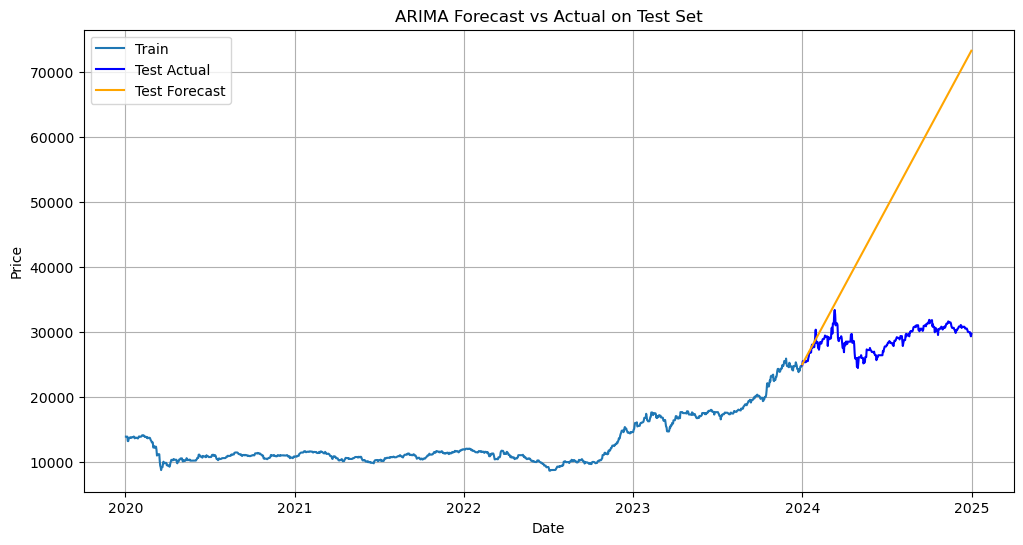

In [157]:
test_dates = test.index

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Price'], label='Train')
plt.plot(test_dates, test['Price'], label='Test Actual', color='blue')
plt.plot(test_dates, forecast_test1, label='Test Forecast', color='orange')
plt.title("ARIMA Forecast vs Actual on Test Set")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

### Using grid search


In [158]:
def grid_search_arima(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(data, order=(p, d, q))
                    model_fit = model.fit()
                    aic = model_fit.aic  # Use AIC to measure model performance
                    if aic < best_score:
                        best_score, best_cfg = aic, (p, d, q)
                    print(f"ARIMA{(p, d, q)} - AIC:{aic}")
                except:
                    continue
    print(f"\nBest ARIMA order (via Grid Search): {best_cfg} with AIC={best_score}")
    return best_cfg

In [159]:
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
best_p, best_d, best_q = grid_search_arima(train['Price'], p_values, d_values, q_values)

ARIMA(0, 0, 0) - AIC:37405.022737425184


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) - AIC:26507.531609478705


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 2) - AIC:25782.463513002775


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 3) - AIC:24408.099878876405


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 4) - AIC:24362.44549676219


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 5) - AIC:24176.911734890422
ARIMA(0, 1, 0) - AIC:18936.355087062177
ARIMA(0, 1, 1) - AIC:18928.197738138224
ARIMA(0, 1, 2) - AIC:18928.808988297893
ARIMA(0, 1, 3) - AIC:18924.9203531726
ARIMA(0, 1, 4) - AIC:18926.756383612832
ARIMA(0, 1, 5) - AIC:18927.04454277124
ARIMA(0, 2, 0) - AIC:19802.47134161865
ARIMA(0, 2, 1) - AIC:18925.928952376704
ARIMA(0, 2, 2) - AIC:18919.287456623522
ARIMA(0, 2, 3) - AIC:18920.50654466742
ARIMA(0, 2, 4) - AIC:18917.939562336094
ARIMA(0, 2, 5) - AIC:18919.53516623513


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 0) - AIC:18961.02572751037


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 1) - AIC:18952.718272823917


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 2) - AIC:18953.298543863842


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 3) - AIC:18949.542110335722


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 4) - AIC:18951.549796673964


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 5) - AIC:18951.67238707297
ARIMA(1, 1, 0) - AIC:18927.471922613207
ARIMA(1, 1, 1) - AIC:18925.83724291128
ARIMA(1, 1, 2) - AIC:18927.827912768837
ARIMA(1, 1, 3) - AIC:18925.762340208537
ARIMA(1, 1, 4) - AIC:18927.51442628988
ARIMA(1, 1, 5) - AIC:18927.95322110256
ARIMA(1, 2, 0) - AIC:19434.084438048623
ARIMA(1, 2, 1) - AIC:18918.875870436375
ARIMA(1, 2, 2) - AIC:18921.641022192627
ARIMA(1, 2, 3) - AIC:18921.837357094104
ARIMA(1, 2, 4) - AIC:18918.25585143138
ARIMA(1, 2, 5) - AIC:18920.217103774645


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 0) - AIC:18952.05205823431


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 1) - AIC:18956.36062494367


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 2) - AIC:18956.710490147


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 3) - AIC:18952.11760961566
ARIMA(2, 0, 4) - AIC:18953.445743013617


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 5) - AIC:18955.376113398695
ARIMA(2, 1, 0) - AIC:18927.85300121932


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 1) - AIC:18927.82960765712


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) - AIC:18926.34221341749
ARIMA(2, 1, 3) - AIC:18927.19237412165
ARIMA(2, 1, 4) - AIC:18929.124335707646
ARIMA(2, 1, 5) - AIC:18928.20028586939
ARIMA(2, 2, 0) - AIC:19260.244632918257
ARIMA(2, 2, 1) - AIC:18925.741762767087
ARIMA(2, 2, 2) - AIC:18922.851726198227
ARIMA(2, 2, 3) - AIC:18917.84407413066


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 4) - AIC:18909.44196682754


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 2, 5) - AIC:18916.136858693306
ARIMA(3, 0, 0) - AIC:18952.40248799774


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(3, 0, 1) - AIC:18956.04891850382


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 0, 2) - AIC:18948.757032011556


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 0, 3) - AIC:18941.711241075558


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(3, 0, 4) - AIC:18940.63442141182


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 5) - AIC:18950.707702430147
ARIMA(3, 1, 0) - AIC:18925.42762347748
ARIMA(3, 1, 1) - AIC:18925.07362228829


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 1, 2) - AIC:18928.93222229709


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3) - AIC:18922.55354786579


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4) - AIC:18920.060075558325


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 5) - AIC:18928.03326975032
ARIMA(3, 2, 0) - AIC:19204.41213588391
ARIMA(3, 2, 1) - AIC:18923.49376058414
ARIMA(3, 2, 2) - AIC:18923.828326790448


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 2, 3) - AIC:18905.381047202645


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 2, 4) - AIC:18920.04953751825


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(3, 2, 5) - AIC:18903.998944129806


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(4, 0, 0) - AIC:18950.357840290428
ARIMA(4, 0, 1) - AIC:18956.222605589894


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4, 0, 2) - AIC:18940.38375413499


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(4, 0, 3) - AIC:18951.834863323074


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(4, 0, 4) - AIC:18959.39955617991


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 5) - AIC:18952.446335809094
ARIMA(4, 1, 0) - AIC:18927.03849103257
ARIMA(4, 1, 1) - AIC:18927.03594915235


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4, 1, 2) - AIC:18929.05550139948
ARIMA(4, 1, 3) - AIC:18921.092298664284
ARIMA(4, 1, 4) - AIC:18922.317343217605


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 5) - AIC:18923.366306008546
ARIMA(4, 2, 0) - AIC:19145.200410645084
ARIMA(4, 2, 1) - AIC:18919.827692167317
ARIMA(4, 2, 2) - AIC:18922.722893367078


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 2, 3) - AIC:18905.769827019212


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 2, 4) - AIC:18918.585704785757


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(4, 2, 5) - AIC:18924.215540267913


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(5, 0, 0) - AIC:18951.920362492296
ARIMA(5, 0, 1) - AIC:18953.881633006695


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(5, 0, 2) - AIC:18947.81036079566


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(5, 0, 3) - AIC:18956.622671573412


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(5, 0, 4) - AIC:18959.380656022026


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 0, 5) - AIC:18956.083862843123
ARIMA(5, 1, 0) - AIC:18927.925074858915
ARIMA(5, 1, 1) - AIC:18928.198413508304


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(5, 1, 2) - AIC:18929.227929375593


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 1, 3) - AIC:18926.03863560522


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 1, 4) - AIC:18929.3999255202


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 1, 5) - AIC:18932.364904461276
ARIMA(5, 2, 0) - AIC:19131.593981020575
ARIMA(5, 2, 1) - AIC:18921.201303439135
ARIMA(5, 2, 2) - AIC:18921.435271681425
ARIMA(5, 2, 3) - AIC:18909.50596027924


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 2, 4) - AIC:18924.885059269807
ARIMA(5, 2, 5) - AIC:18923.31682028648

Best ARIMA order (via Grid Search): (3, 2, 5) with AIC=18903.998944129806


C:\Users\dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model2 = ARIMA(train['Price'], order=(best_p, best_d, best_q))
model_fit2 = model2.fit()
print(model_fit2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1460
Model:                 ARIMA(3, 2, 3)   Log Likelihood               -9445.691
Date:                Sat, 07 Jun 2025   AIC                          18905.381
Time:                        23:48:51   BIC                          18942.375
Sample:                    01-02-2020   HQIC                         18919.182
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4778      0.017    -86.398      0.000      -1.511      -1.444
ar.L2         -0.8409      0.026    -31.957      0.000      -0.893      -0.789
ar.L3          0.1002      0.017      6.034      0.0

c:\Users\Tasnim\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


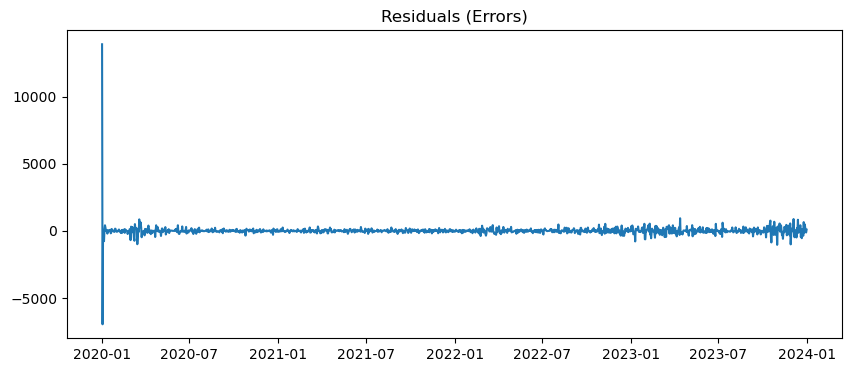

In [161]:
residuals2 = model_fit.resid


plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals (Errors)")
plt.show()

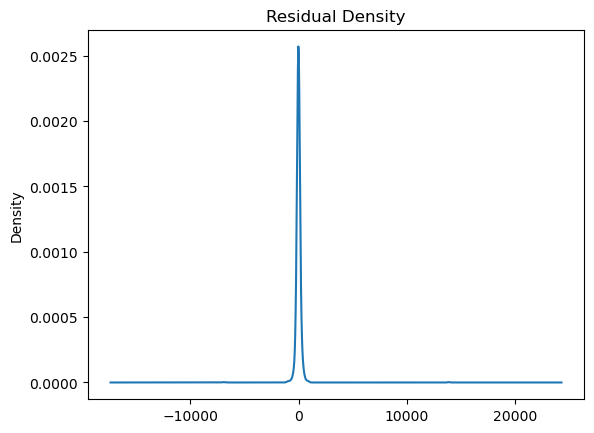

In [162]:
residuals2.plot(kind='kde', title='Residual Density')
plt.show()


In [164]:
import statsmodels.api as sm


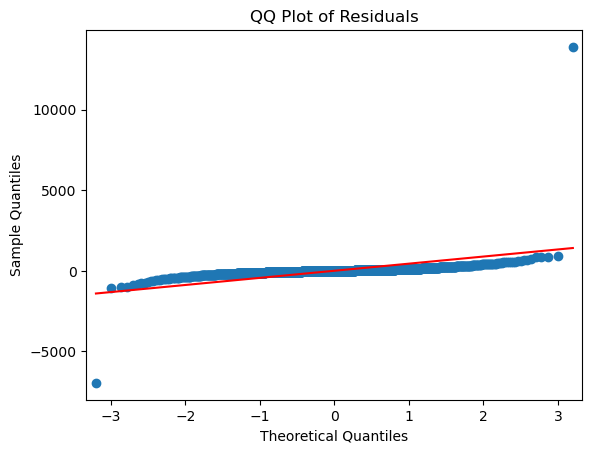

In [165]:
sm.qqplot(residuals2, line='s')
plt.title("QQ Plot of Residuals")
plt.show()

In [167]:
from statsmodels.graphics.tsaplots import plot_acf


In [169]:
from statsmodels.graphics.tsaplots import plot_pacf


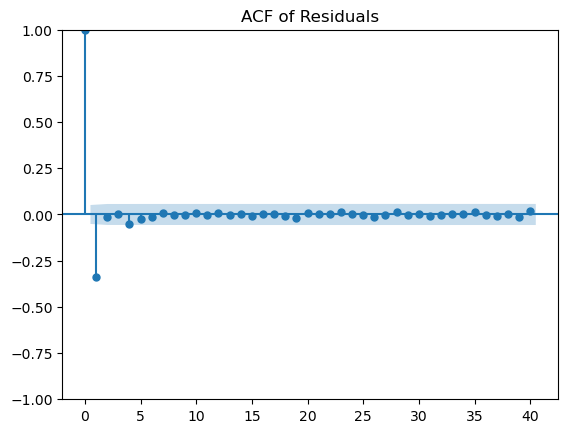

C:\Users\dell\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


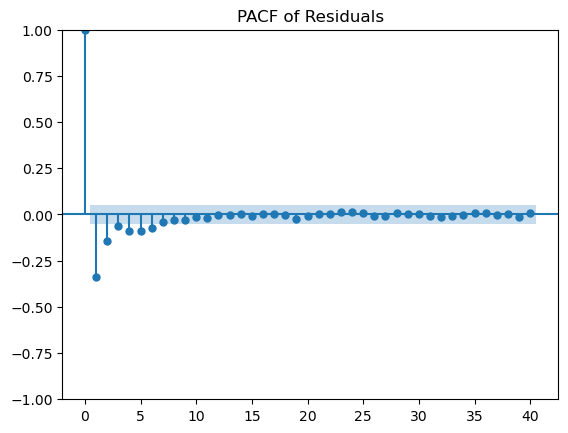

In [170]:
plot_acf(residuals2, lags=40)
plt.title("ACF of Residuals")
plt.show()

plot_pacf(residuals2, lags=40)
plt.title("PACF of Residuals")
plt.show()

In [172]:
forecast_test2 = model_fit.forecast(steps=len(test))


In [173]:
forecast_test2 = model_fit2.forecast(steps=len(test))

NameError: name 'model_fit2' is not defined

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Price'], forecast_test2))
mae = mean_absolute_error(test['Price'], forecast_test2)
mape = np.mean(np.abs((test['Price'] - forecast_test2) / test['Price'])) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 2909.38
MAE: 2541.47
MAPE: 8.54%


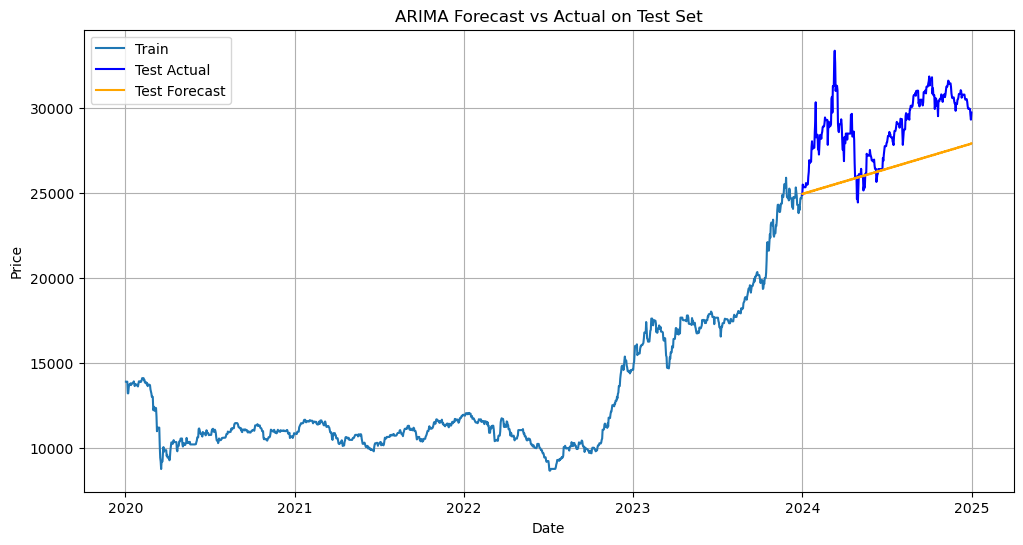

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Price'], label='Train')
plt.plot(test_dates, test['Price'], label='Test Actual', color='blue')
plt.plot(test_dates, forecast_test2, label='Test Forecast', color='orange')
plt.title("ARIMA Forecast vs Actual on Test Set")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

### Seasonal ARIMA (SARIMA)


In [ ]:
print("\nFinding best parameters using Auto ARIMA...")
auto_arima_model = pm.auto_arima(train['Price'], seasonal=True, stepwise=True, trace=True)
best_p, best_d, best_q = auto_arima_model.order
print(f"\nBest ARIMA order: ({best_p}, {best_d}, {best_q})")


Finding best parameters using Auto ARIMA...
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=19802.471, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=19434.084, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=19260.245, Time=0.11 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=19204.412, Time=0.10 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=19145.200, Time=0.22 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=19131.594, Time=0.27 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=3.44 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=2.51 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=19133.591, Time=0.52 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 8.566 seconds

Best ARIMA order: (5, 2, 0)


In [ ]:
sarimamodel = SARIMAX(train['Price'], order=(best_p, best_d, best_q), seasonal_order=(1,1,1,12)).fit()


In [ ]:
print(sarimamodel.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Price   No. Observations:                 1460
Model:             SARIMAX(5, 2, 0)x(1, 1, [1], 12)   Log Likelihood               -9512.705
Date:                              Sat, 07 Jun 2025   AIC                          19041.410
Time:                                      23:49:10   BIC                          19083.623
Sample:                                  01-02-2020   HQIC                         19057.165
                                       - 12-31-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7613      0.017    -46.018      0.000      -0.794      -0.729
ar.L2         -0.59

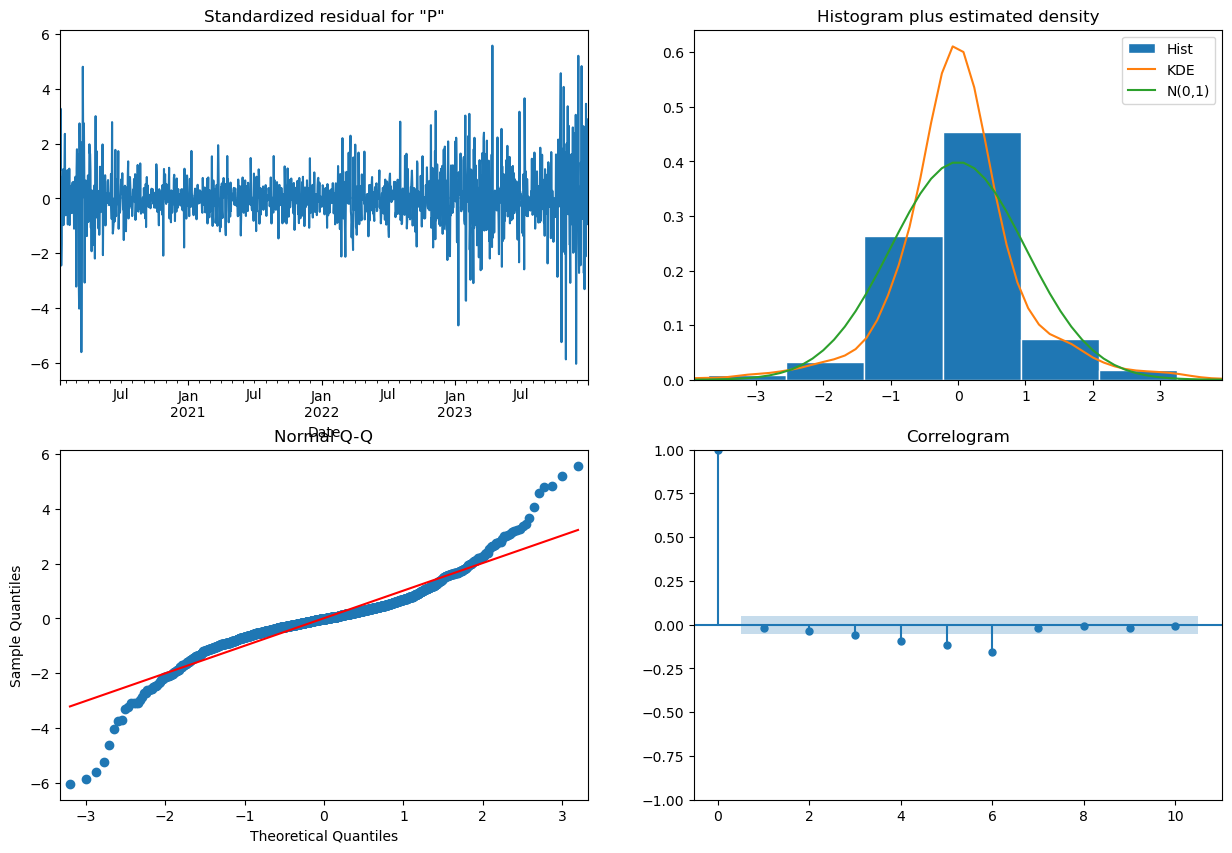

In [ ]:
sarimamodel.plot_diagnostics(figsize=(15, 10))
plt.show()

In [ ]:
forecast_test3 = sarimamodel.forecast(steps=len(test))

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Price'], forecast_test3))
mae = mean_absolute_error(test['Price'], forecast_test3)
mape = np.mean(np.abs((test['Price'] - forecast_test3) / test['Price'])) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 26912.59
MAE: 22568.18
MAPE: 76.55%


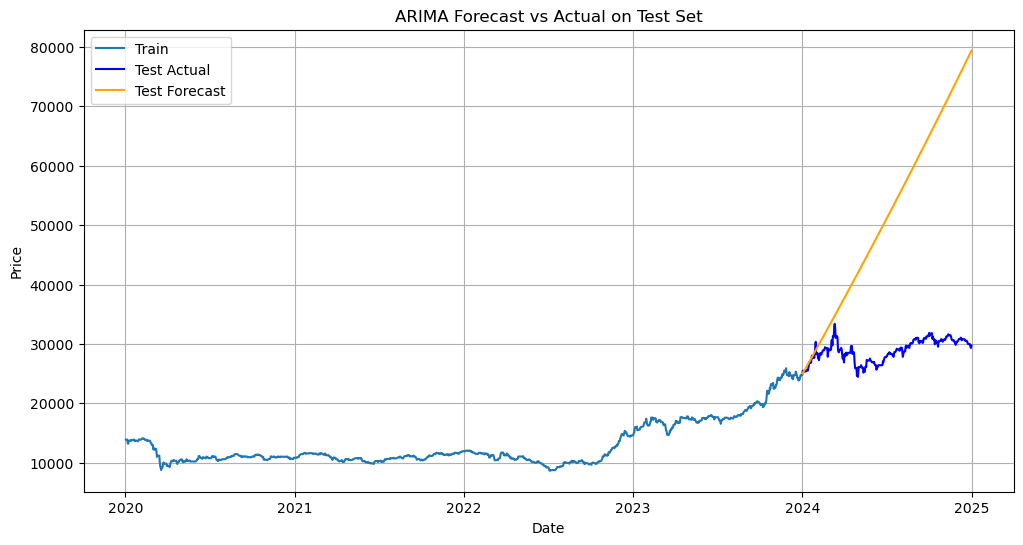

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Price'], label='Train')
plt.plot(test_dates, test['Price'], label='Test Actual', color='blue')
plt.plot(test_dates, forecast_test3, label='Test Forecast', color='orange')
plt.title("ARIMA Forecast vs Actual on Test Set")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

### Exogenous Variables (SARIMAX)


In [ ]:
X = train[['Vol.', 'ATR', 'RSI', 'MACD']]

In [ ]:
exgosarima = SARIMAX(train['Price'], exog=X, order=(best_p, best_d, best_q)).fit()

c:\Users\Tasnim\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
print(exgosarima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1460
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -9036.049
Date:                Sat, 07 Jun 2025   AIC                          18092.098
Time:                        23:49:14   BIC                          18144.946
Sample:                    01-02-2020   HQIC                         18111.814
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Vol.        8.001e-08   3.91e-08      2.045      0.041    3.34e-09    1.57e-07
ATR           -0.2828      0.108     -2.613      0.009      -0.495      -0.071
RSI           11.2025      0.465     24.067      0.0

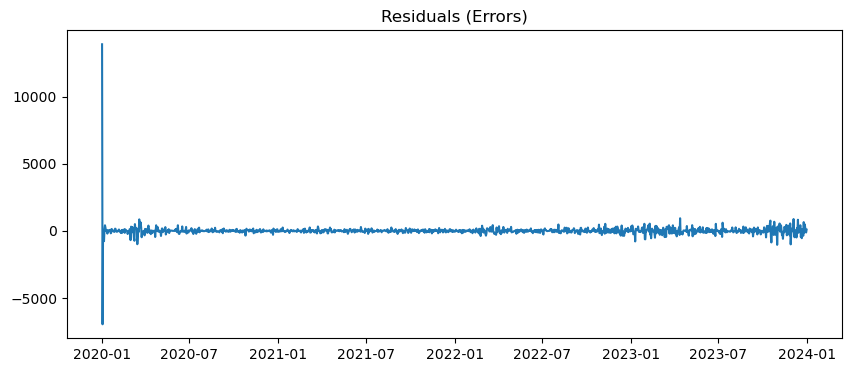

In [ ]:
residuals3 = exgosarima.resid

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals (Errors)")
plt.show()

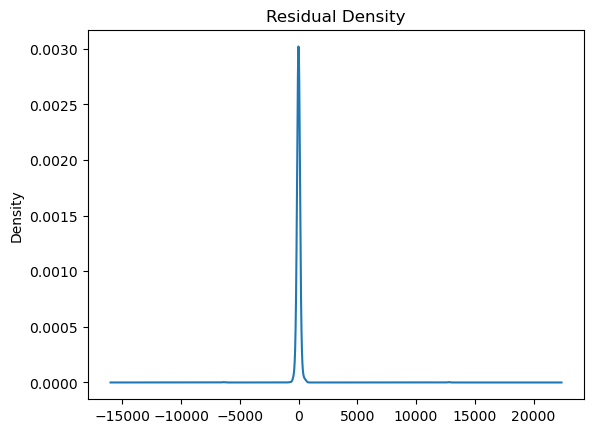

In [ ]:
residuals3.plot(kind='kde', title='Residual Density')
plt.show()


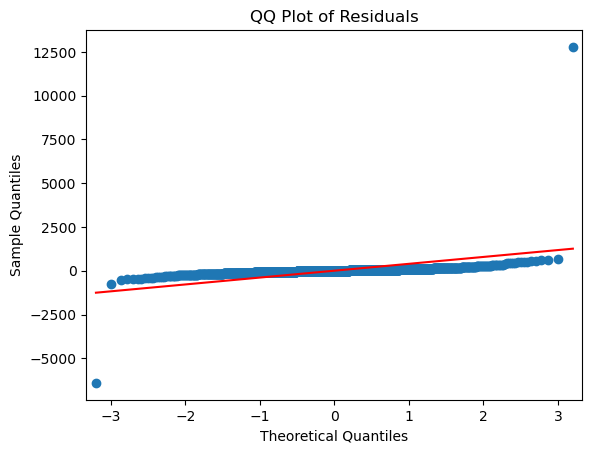

In [ ]:
sm.qqplot(residuals3, line='s')
plt.title("QQ Plot of Residuals")
plt.show()

In [ ]:
forecastexgosarima = exgosarima.forecast(steps=len(test), exog=test[['Vol.', 'ATR', 'RSI', 'MACD']])

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Price'], forecastexgosarima))
mae = mean_absolute_error(test['Price'], forecastexgosarima)
mape = np.mean(np.abs((test['Price'] - forecastexgosarima) / test['Price'])) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 8790.66
MAE: 7976.33
MAPE: 27.17%


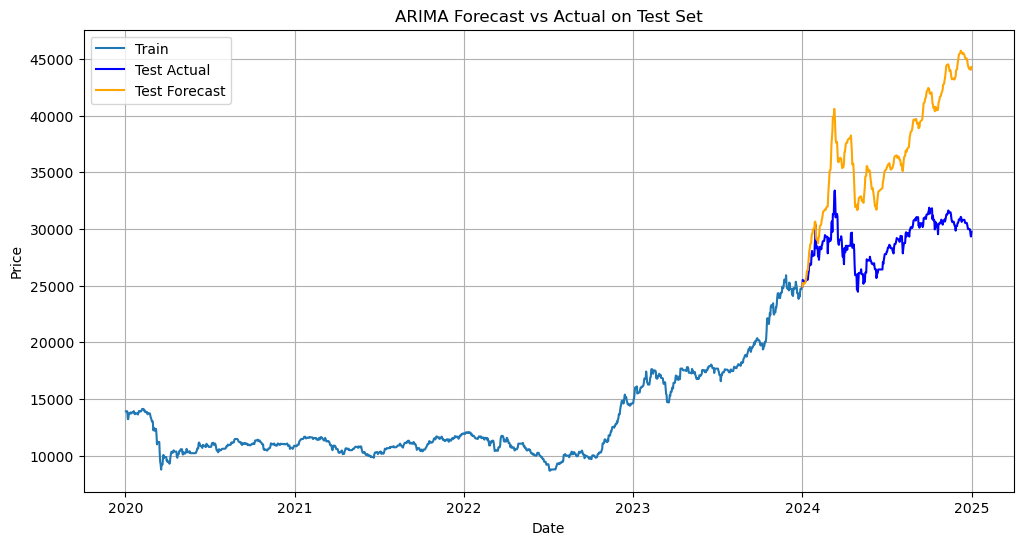

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Price'], label='Train')
plt.plot(test_dates, test['Price'], label='Test Actual', color='blue')
plt.plot(test_dates, forecastexgosarima, label='Test Forecast', color='orange')
plt.title("ARIMA Forecast vs Actual on Test Set")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# LSTM


In [ ]:
X = stock2020[['Vol.', 'ATR', 'RSI', 'MACD']].values
y = stock2020['Price'].values.reshape(-1, 1)

In [ ]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [ ]:

print(f"\nShape of X after scaling: {X_scaled.shape}")
print(f"Shape of y after scaling: {y_scaled.shape}")


Shape of X after scaling: (1826, 4)
Shape of y after scaling: (1826, 1)


In [ ]:
# to predict the next point.
def create_sequences(data, target, time_steps):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        # Xs will be the time sequence of features (input)
        Xs.append(data[i:(i + time_steps)])
        # ys will be the target value (output), which is the value right after the sequence
        ys.append(target[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 21

In [ ]:
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

In [ ]:
print(f"\nShape of X_seq after creating sequences: {X_seq.shape}") # (num_samples, time_steps, num_features)
print(f"Shape of y_seq after creating sequences: {y_seq.shape}")   # (num_samples, 1)


Shape of X_seq after creating sequences: (1805, 21, 4)
Shape of y_seq after creating sequences: (1805, 1)


In [ ]:
train_size = int(len(X_seq) * 0.8) # 80% for training, 20% for testing
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


In [ ]:
print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (1444, 21, 4)
Shape of y_train: (1444, 1)
Shape of X_test: (361, 21, 4)
Shape of y_test: (361, 1)


In [ ]:
model = Sequential()
# First LSTM layer: input_shape must match (time_steps, num_features).
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) # Dropout layer to prevent overfitting

# Second LSTM layer: No need for return_sequences=True if this is the last LSTM layer.
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2)) # Dropout layer to prevent overfitting

# Output Dense layer: 1 unit for a single price prediction.
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error') # Adam optimizer, MSE as loss function for regression
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 21, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nStarting model training...")
history = model.fit(X_train, y_train,
                    epochs=100,      # Number of training iterations. .
                    batch_size=32,   # Number of samples per gradient update.
                    validation_split=0.1, # A portion of training data used for validation
                    verbose=1)       # Show training progress

print("Model training finished.")


Starting model training...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0103 - val_loss: 0.0752
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0065 - val_loss: 0.0837
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0076 - val_loss: 0.0787
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0072 - val_loss: 0.0941
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0067 - val_loss: 0.0825
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0070 - val_loss: 0.0612
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0071 - val_loss: 0.0708
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0065 - val_loss: 0.0598
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0072 - val_loss: 0.0554
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0063 - val_loss: 0.0549
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0069 - val_loss: 0.0761
Epoch 12/100
41/41 ━━━━━

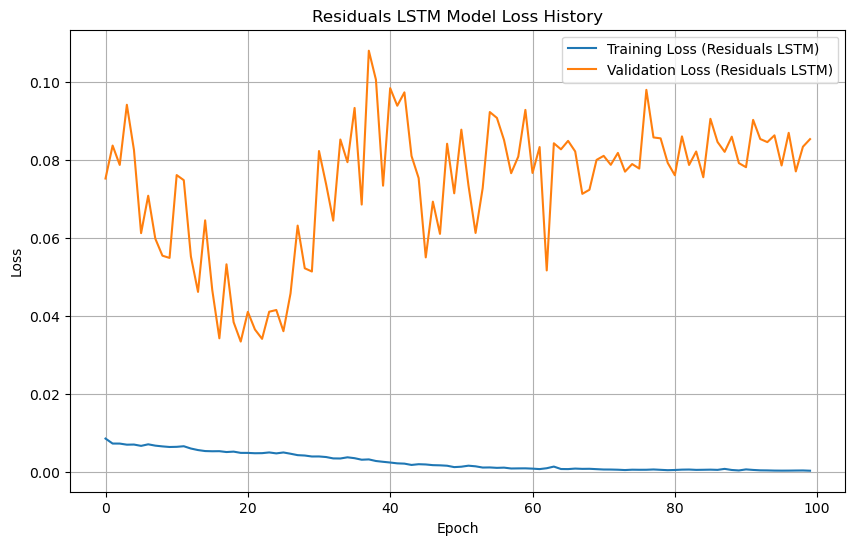

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (Residuals LSTM)')
plt.plot(history.history['val_loss'], label='Validation Loss (Residuals LSTM)')
plt.title('Residuals LSTM Model Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_pred_scaled = model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [ ]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

In [ ]:
print(f"\nModel Evaluation on Test Data:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Model Evaluation on Test Data:
Root Mean Squared Error (RMSE): 14258.60
Mean Absolute Error (MAE): 14019.38
Mean Absolute Percentage Error (MAPE): 48.11%


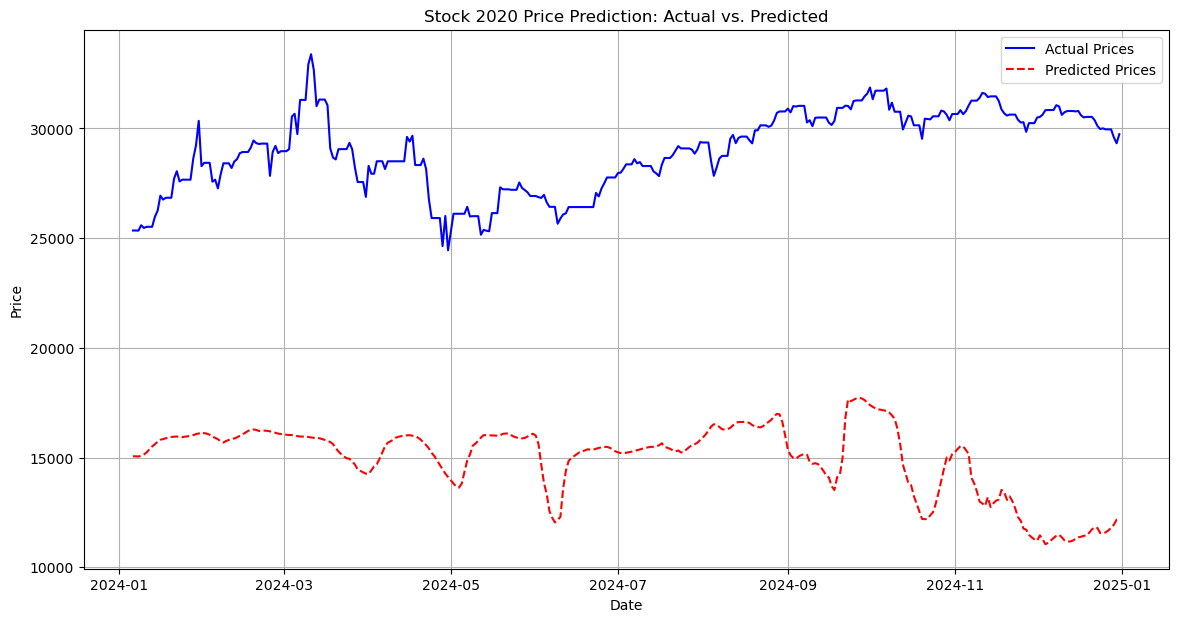

In [ ]:
plt.figure(figsize=(14, 7))
test_dates = stock2020.index[len(stock2020) - len(y_test_actual):]
plt.plot(test_dates, y_test_actual, label='Actual Prices', color='blue')
plt.plot(test_dates, y_pred, label='Predicted Prices', color='red', linestyle='--')
plt.title('Stock 2020 Price Prediction: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df_results = pd.DataFrame({'Actual Price': y_test_actual.flatten(), 'Predicted Price': y_pred.flatten()})
print("\nComparison of Actual vs. Predicted Prices (First 10 values):")
print(df_results.head(10))


Comparison of Actual vs. Predicted Prices (First 10 values):
   Actual Price  Predicted Price
0      25350.28     15061.974609
1      25350.28     15061.082031
2      25344.63     15051.839844
3      25589.99     15085.805664
4      25466.75     15144.460938
5      25519.25     15240.612305
6      25519.25     15382.541016
7      25519.25     15511.851562
8      25974.84     15610.114258
9      26250.73     15731.655273


# Hybrid approach (LSTM-ARIMA)


### Calculate ARIMA Residuals for LSTM Training


In [ ]:
arima_train_fitted_values = model_fit2.fittedvalues
# Calculate residuals
arima_train_residuals = train['Price'] - arima_train_fitted_values

print(f"Shape of ARIMA training residuals: {arima_train_residuals.shape}")
print(f"First 5 ARIMA training residuals:\n{arima_train_residuals.head()}")

Shape of ARIMA training residuals: (1460,)
First 5 ARIMA training residuals:
Date
2020-01-02    13899.540000
2020-01-03    -6959.977506
2020-01-04     -294.460671
2020-01-05     -164.774399
2020-01-06     -776.711665
Freq: D, dtype: float64


### Prepare Data for LSTM (Residuals)


In [ ]:
# Scalers for features and residuals
scaler_X = MinMaxScaler()
scaler_residuals = MinMaxScaler()

# Scale features for LSTM training (using train data)
X_train_features = train[['Vol.', 'ATR', 'RSI', 'MACD']].values
X_train_scaled = scaler_X.fit_transform(X_train_features)

# Scale ARIMA residuals for LSTM target
y_train_residuals_scaled = scaler_residuals.fit_transform(arima_train_residuals.values.reshape(-1, 1))

In [ ]:
# Create sequences for LSTM training
# X_seq_lstm_train will contain sequences of technical indicators.
# y_seq_lstm_train will contain the corresponding scaled ARIMA residuals.
X_seq_lstm_train, y_seq_lstm_train = create_sequences(X_train_scaled, y_train_residuals_scaled, TIME_STEPS)

In [ ]:
print(f"Shape of X_seq_lstm_train: {X_seq_lstm_train.shape}") # (num_samples, time_steps, num_features)
print(f"Shape of y_seq_lstm_train: {y_seq_lstm_train.shape}")   # (num_samples, 1)

Shape of X_seq_lstm_train: (1439, 21, 4)
Shape of y_seq_lstm_train: (1439, 1)


### LSTM Model Training on Residuals


In [ ]:
model_lstm_residuals = Sequential()
model_lstm_residuals.add(LSTM(units=50, return_sequences=True, input_shape=(X_seq_lstm_train.shape[1], X_seq_lstm_train.shape[2])))
model_lstm_residuals.add(Dropout(0.2))
model_lstm_residuals.add(LSTM(units=50, return_sequences=False))
model_lstm_residuals.add(Dropout(0.2))
model_lstm_residuals.add(Dense(units=1))
model_lstm_residuals.compile(optimizer='adam', loss='mean_squared_error')
model_lstm_residuals.summary()

c:\Users\Tasnim\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 21, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nStarting LSTM model training on residuals...")
history_hybrid_lstm = model_lstm_residuals.fit(X_seq_lstm_train, y_seq_lstm_train,
                                                epochs=100,
                                                batch_size=32,
                                                validation_split=0.1,
                                                verbose=1)
print("LSTM model training on residuals finished.")



Starting LSTM model training on residuals...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0262 - val_loss: 0.0038
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010 - val_loss: 6.2515e-04
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.5979e-04 - val_loss: 6.9407e-04
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.8669e-04 - val_loss: 2.5128e-04
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.4403e-04 - val_loss: 2.4782e-04
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.5734e-04 - val_loss: 2.9300e-04
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.6315e-04 - val_loss: 1.9997e-04
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/s

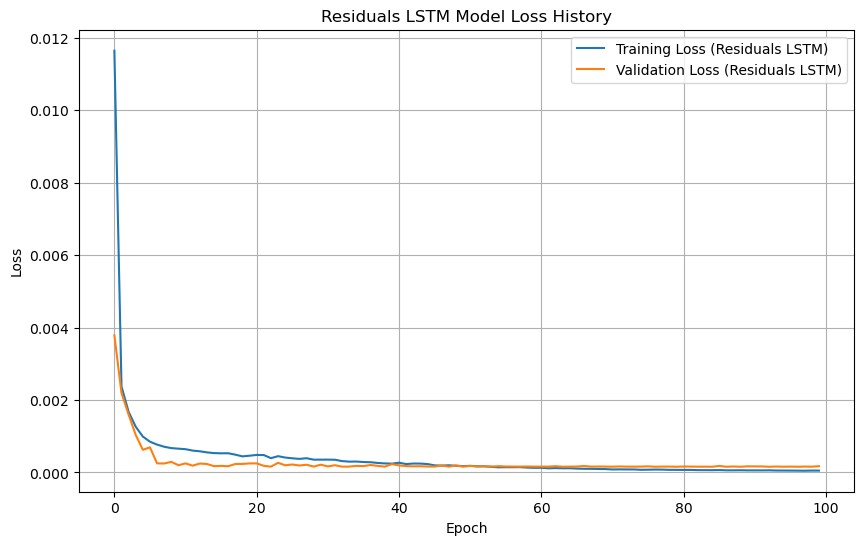

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_hybrid_lstm.history['loss'], label='Training Loss (Residuals LSTM)')
plt.plot(history_hybrid_lstm.history['val_loss'], label='Validation Loss (Residuals LSTM)')
plt.title('Residuals LSTM Model Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Hybrid Model Forecasting


In [ ]:
arima_forecast_test_full = model_fit2.forecast(steps=len(test))

In [ ]:
X_test_features = test[['Vol.', 'ATR', 'RSI', 'MACD']].values
X_test_scaled = scaler_X.transform(X_test_features)

In [ ]:
X_seq_lstm_test, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 1)), TIME_STEPS)

In [ ]:
lstm_residuals_scaled_pred = model_lstm_residuals.predict(X_seq_lstm_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [ ]:
# Inverse transform to get actual residual values
lstm_residuals_pred = scaler_residuals.inverse_transform(lstm_residuals_scaled_pred)

In [ ]:
arima_forecast_component = arima_forecast_test_full[TIME_STEPS:]
lstm_residuals_component = lstm_residuals_pred.flatten() 

In [ ]:
hybrid_forecast = arima_forecast_component + lstm_residuals_component

In [ ]:

print(f"Length of ARIMA forecast component for hybrid: {len(arima_forecast_component)}")
print(f"Length of LSTM residual forecast component: {len(lstm_residuals_component)}")
print(f"Length of final hybrid forecast: {len(hybrid_forecast)}")


Length of ARIMA forecast component for hybrid: 345
Length of LSTM residual forecast component: 345
Length of final hybrid forecast: 345


In [ ]:
y_test_actual_hybrid = test['Price'].iloc[TIME_STEPS:]
print(f"Length of actual test prices for hybrid evaluation: {len(y_test_actual_hybrid)}")

Length of actual test prices for hybrid evaluation: 345


### Evaluate Hybrid Model


In [ ]:
rmse_hybrid = np.sqrt(mean_squared_error(y_test_actual_hybrid, hybrid_forecast))
mae_hybrid = mean_absolute_error(y_test_actual_hybrid, hybrid_forecast)
mape_hybrid = np.mean(np.abs((y_test_actual_hybrid - hybrid_forecast) / y_test_actual_hybrid)) * 100

print(f"\nHybrid ARIMA-LSTM Model Evaluation on Test Data:")
print(f"Root Mean Squared Error (RMSE): {rmse_hybrid:.2f}")
print(f"Mean Absolute Error (MAE): {mae_hybrid:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_hybrid:.2f}%")


Hybrid ARIMA-LSTM Model Evaluation on Test Data:
Root Mean Squared Error (RMSE): 3048.75
Mean Absolute Error (MAE): 2703.89
Mean Absolute Percentage Error (MAPE): 9.07%


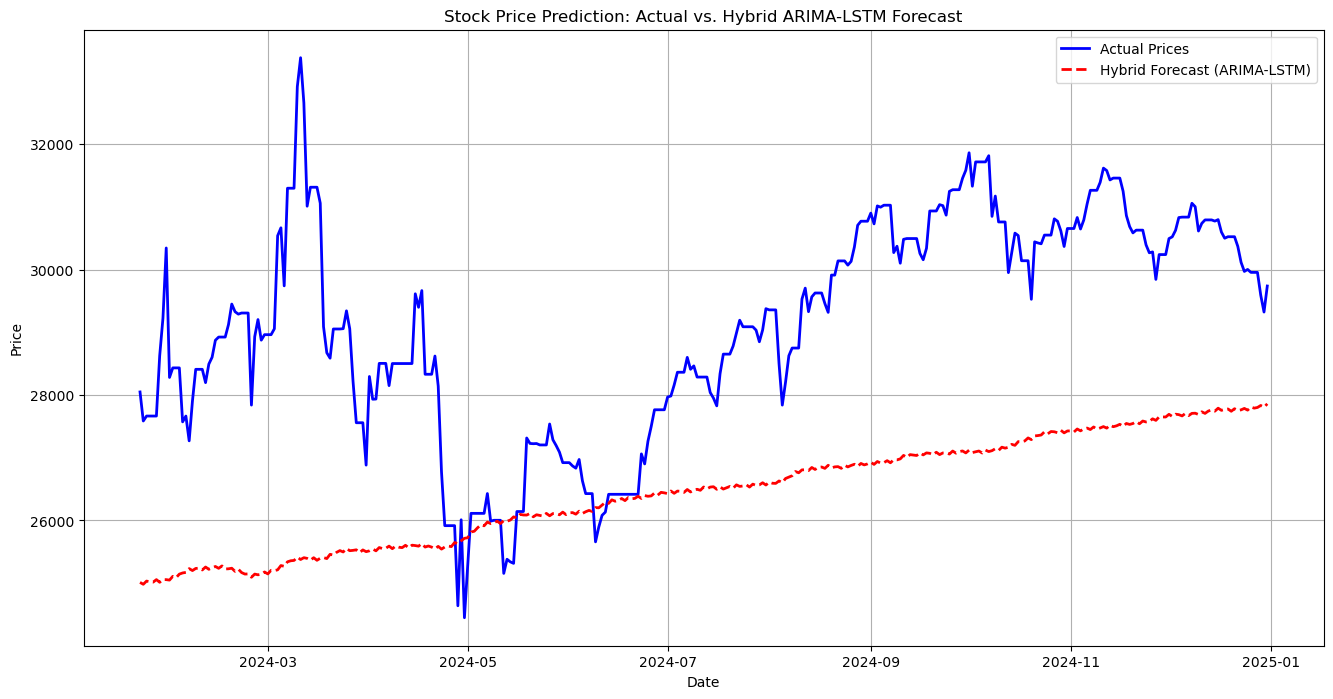

In [ ]:
plt.figure(figsize=(16, 8))

test_dates_hybrid = test.index[TIME_STEPS:]
plt.plot(test_dates_hybrid, y_test_actual_hybrid, label='Actual Prices', color='blue', linewidth=2)
plt.plot(test_dates_hybrid, hybrid_forecast, label='Hybrid Forecast (ARIMA-LSTM)', color='red', linestyle='--', linewidth=2)
plt.title('Stock Price Prediction: Actual vs. Hybrid ARIMA-LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()